In [181]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict
from matplotlib.ticker import LogLocator

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

data_kgb_l = nested_dict(5, list)
data_kgb_s = nested_dict(5, list)

import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

In [182]:
# === Input redshifts to show on the plots ===
target_z = [2, 1, 0.5]  

# KGB-evolution

In [183]:
# ──────────────────────────────────────────────────────────────────────────────
#                       CONFIGURATION FLAG
use_all_sims = True # ← set to False to process *only* sim1, True to combine 3
show_sim_plots = True  # ← set to False if you dont want to see the simulation plots,
kgb_sim_data = True
# ──────────────────────────────────────────────────────────────────────────────

# 1) PARAMETERS FOR YOUR SIMULATIONS
sim1 = dict(path="/home/ahmad/kgb-master/data/3072-90000/", ngrid=3072, boxsize=90000)

# sim1 = dict(path='/home/ahmad/kgb-master/data/3072-4000-ab=0/',
#             ngrid=3072, boxsize=4000)
sim2 = dict(path="/home/ahmad/kgb-master/data/4096-15000/", ngrid=4096, boxsize=15000)
# sim3 = dict(path='/home/ahmad/kgb-master/data/3072-8500/',
#             ngrid=3072, boxsize=8500)

sim3 = dict(path="/home/ahmad/kgb-master/data/3072-4000/", ngrid=3072, boxsize=4000)

# which simulations to stitch?
sims = [sim1]
if use_all_sims:
    sims += [sim2, sim3]


################################################################################################################
#                                              background file
if kgb_sim_data:
    with open(f"{sim1['path']}/file_background.dat") as f:
        lines = f.readlines()

    fourpiG_val = float(
        next(
            line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")
        )
    )
    H0_val = float(
        next(
            line.split("=")[1].strip()
            for line in lines
            if line.startswith("# H0[1/Mpc]")
        )
    )

    norm_kgb = np.sqrt(2 * fourpiG_val / 3) / H0_val

    bg_kgb = np.loadtxt(f"{sim1['path']}/file_background.dat")

    # scale factor and redshift
    a_kgb = bg_kgb[:, 2]
    z_kgb = bg_kgb[:, 3]

    # z_kgb = [0 if x < 0 else x for x in z_kgb]
    # z_kgb[-2], z_kgb[-1] = 0.01, 0

    # Conformal Hubble parameter and its derivative
    Hconf_kgb = bg_kgb[:, 5]
    Hconf_prime_kgb = bg_kgb[:, 6]
    Hconf_prime_prime_kgb = bg_kgb[:, 7]

    # alpha parameters and their derivatives
    alpha_K_kgb = bg_kgb[:, 17]
    alpha_B_kgb = bg_kgb[:, 18]
    alpha_K_prime_kgb = bg_kgb[:, 19]
    alpha_B_prime_kgb = bg_kgb[:, 20]

    # dark energy density and pressure and their derivatives
    rho_smg_kgb = bg_kgb[:, 13]
    p_smg_kgb = bg_kgb[:, 14]
    rho_smg_prime_kgb = bg_kgb[:, 15]
    p_smg_prime_kgb = bg_kgb[:, 16]
    cs2_kgb = bg_kgb[:, 21]

    H_hiclass = bg_kgb[:, 4]

    # other background values
    rho_cdm_kgb = bg_kgb[:, 8]
    rho_b_kgb = bg_kgb[:, 9]
    rho_crit_kgb = bg_kgb[:, 12]

############################################################################################################
#                                         hiclass ini parameters

parser = ConfigParser()
with open(f"{sim1['path']}/file_classparameters.ini") as lines:
    lines = chain(
        ("[top]",), lines
    )  # This line produce a fake section header called top
    parser.read_file(lines)

Omega_fld = float(parser.get("top", "Omega_fld"))
Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
Omega_smg = float(parser.get("top", "Omega_smg"))

Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))
Omega_g = float(parser.get("top", "Omega_g"))
Omega_ur = float(parser.get("top", "Omega_ur"))

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(",")
Omega_kgb = float(expansion_smg_list[0].strip())

expansion_model_str = parser.get("top", "expansion_model")

############################################################################################################
#                                   KGB-evolution used.ini parameters

with open(f"{sim1['path']}/file_settings_used.ini") as lines:
    lines = chain(
        ("[top]",), lines
    )  # This line produce a fake section header called top
    parser.read_file(lines)

k_pivot = float(parser.get("top", "k_pivot"))
A_s = float(parser.get("top", "A_s"))
n_s = float(parser.get("top", "n_s"))
h = float(parser.get("top", "h"))

omega_b = float(parser.get("top", "omega_b"))
omega_cdm = float(parser.get("top", "omega_cdm"))


gravity_model = parser.get("top", "gravity_model")

# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(",")

# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())


# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split("e")
    exponent = exponent.lstrip("+").lstrip("0") or "0"
    return f"{mantissa} \\times 10^{{{exponent}}}"


# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(",")

w_kgb = float(expansion_smg_list[0].strip())
w_a_kgb = float(expansion_smg_list[1].strip())

# n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))

#############################################################################################################3


##################################################################################
#                                                                                #
#                                                                                #
#                                 LINKING SIMULATIONS                            #
#                                                                                #
#                                                                                #
##################################################################################


# common list of P(k) suffixes
pknames = [
    "delta_kgb",
    "delta",
    "phi",
    "phi_prime",
    "pi_k",
    "zeta",
    "deltakgb_deltam",
]

# read your redshifts once (always from sim1’s ini)
z = []
with open(f"{sim1['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith("Pk redshifts"):
            z = [float(x) for x in line.split("=")[1].split("#")[0].split(",")]
            break


def load_simulation(path, z, pknames):
    data = {name: [] for name in ["k"] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data["k"].append(arr[:, 0])
                got_k = True
            data[name].append(arr[:, 1])
    return data


def trim_snapshot(k, fields, ngrid, boxsize, remove_first=5, nyquist_frac=1 / 13):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    k_trimmed = k[keep]
    return k_trimmed, {name: arr[keep] for name, arr in fields.items()}


# load whichever sims are needed
data1 = load_simulation(sim1["path"], z, pknames)
if use_all_sims:
    data2 = load_simulation(sim2["path"], z, pknames)
    data3 = load_simulation(sim3["path"], z, pknames)

# prepare output
final = {name: [] for name in ["k"] + pknames}

for iz in range(len(z)):
    # always trim sim1 with the default (remove_first=5, nyquist_frac=1/13)
    k_acc, f_acc = trim_snapshot(
        data1["k"][iz],
        {n: data1[n][iz] for n in pknames},
        sim1["ngrid"],
        sim1["boxsize"],
    )

    if use_all_sims:
        # sim2: remove_first=3, nyquist_frac=1/10
        k2, f2 = trim_snapshot(
            data2["k"][iz],
            {n: data2[n][iz] for n in pknames},
            sim2["ngrid"],
            sim2["boxsize"],
            remove_first=3,
            nyquist_frac=1 / 11,
        )
        j2 = np.searchsorted(k2, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])

        # sim3: remove_first=23, nyquist_frac=0.5
        k3, f3 = trim_snapshot(
            data3["k"][iz],
            {n: data3[n][iz] for n in pknames},
            sim3["ngrid"],
            sim3["boxsize"],
            remove_first=23,
            nyquist_frac=0.5,
        )
        j3 = np.searchsorted(k3, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])

    # store result for this redshift
    final["k"].append(k_acc)
    for name in pknames:
        final[name].append(f_acc[name])
        
        
#########################################################################################################
#                                                  mu function

rho_smg_f = interp1d(z_kgb,rho_smg_kgb, kind = 'cubic' )
rho_cdm_f = interp1d(z_kgb,rho_cdm_kgb, kind = 'cubic' )
rho_b_f = interp1d(z_kgb,rho_b_kgb, kind = 'cubic' )
rho_crit_f = interp1d(z_kgb,rho_crit_kgb, kind = 'cubic' )

# 2) Initialize the mu list in your final dict
final["mu"] = [None] * len(z)

# 3) Now compute mu for each redshift index
for zind, z_val in enumerate(z):
    delta_kgb = final["delta_kgb"][zind]
    delta_m   = final["delta"][zind]
    # note: ensure delta arrays are positive before sqrt
    final["mu"][zind] = 1 + rho_smg_f(z_val) * np.sqrt(delta_kgb) / (
        (rho_cdm_f(z_val) + rho_b_f(z_val)) * np.sqrt(delta_m)
    )
    
#########################################################################################################
#                                matter power spectrum normalization to hiclass 

# unnormalaized
final['delta_unnorm'] = [arr.copy() for arr in final['delta']]

# normalize the ‘delta’ spectrum always
for iz in range(len(z)):
    ktot = final["k"][iz]
    norm = (2 * np.pi**2) / (ktot**3)
    final["delta"][iz] *= norm




# Done: if use_all_sims=False you'll have only sim1 trimmed;
# if True you get the 3-sim stitch as before.

# k-evolution

In [184]:
import numpy as np
from configparser import ConfigParser

from itertools import chain

# Configuration Flags for K-essence
use_all_sims_kess = True # False to process only sim1_kess, True to stitch all three
show_sim_plots_kess = True  # Toggle simulation plots
kess_sim_data = True  # Load background data

# 1) Simulation Definitions for K-essence

# sim1_kess = dict(
#     path="/home/ahmad/kgb-master/data/snapshots-kess", ngrid=1200, boxsize=800
# )

sim1_kess = dict(
    path="/home/ahmad/kgb-master/data/3072-90000-ab=0/", ngrid=3072, boxsize=90000
)
sim2_kess = dict(
    path="/home/ahmad/kgb-master/data/4096-15000-ab=0/", ngrid=4096, boxsize=15000
)
sim3_kess = dict(
    path="/home/ahmad/kgb-master/data/3072-4000-ab=0/", ngrid=3072, boxsize=4000
)

# Select which simulations to stitch
sims_kess = [sim1_kess]
if use_all_sims_kess:
    sims_kess += [sim2_kess, sim3_kess]

# Load background quantities from sim1_kess
if kess_sim_data:
    with open(f"{sim1_kess['path']}/file_background.dat") as f:
        lines = f.readlines()

    fourpiG_val_kess = float(
        next(
            line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")
        )
    )
    H0_val_kess = float(
        next(
            line.split("=")[1].strip()
            for line in lines
            if line.startswith("# H0[1/Mpc]")
        )
    )
    norm_kess = np.sqrt(2 * fourpiG_val_kess / 3) / H0_val_kess

    bg_kess = np.loadtxt(f"{sim1_kess['path']}/file_background.dat")
    a_kess = bg_kess[:, 2]
    z_kess_bg = bg_kess[:, 3]
    Hconf_kess = bg_kess[:, 5]
    Hconf_prime_kess = bg_kess[:, 6]
    Hconf_prime_prime_kess = bg_kess[:, 7]

    alpha_K_kess = bg_kess[:, 17]
    alpha_B_kess = bg_kess[:, 18]
    alpha_K_prime_kess = bg_kess[:, 19]
    alpha_B_prime_kess = bg_kess[:, 20]

    rho_smg_kess = bg_kess[:, 13]
    p_smg_kess = bg_kess[:, 14]
    rho_smg_prime_kess = bg_kess[:, 15]
    p_smg_prime_kess = bg_kess[:, 16]
    cs2_kess = bg_kess[:, 21]

    H_hiclass_kess = bg_kess[:, 4]
    rho_cdm_kess = bg_kess[:, 8]
    rho_b_kess = bg_kess[:, 9]
    
    rho_crit_kess = bg_kess[:, 12]


# Read INI parameters (class settings) from sim1_kess
parser_kess = ConfigParser()
with open(f"{sim1_kess['path']}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines)
    parser_kess.read_file(lines)

Omega_fld_kess = float(parser_kess.get("top", "Omega_fld"))
Omega_Lambda_kess = float(parser_kess.get("top", "Omega_Lambda"))
Omega_smg_kess = float(parser_kess.get("top", "Omega_smg"))
Omega_b_kess = float(parser_kess.get("top", "Omega_b"))
Omega_cdm_kess = float(parser_kess.get("top", "Omega_cdm"))
Omega_g_kess = float(parser_kess.get("top", "Omega_g"))
Omega_ur_kess = float(parser_kess.get("top", "Omega_ur"))

# Read evolution settings (KGB-evolution) from sim1_kess
with open(f"{sim1_kess['path']}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines)
    parser_kess.read_file(lines)

k_pivot_kess = float(parser_kess.get("top", "k_pivot"))
A_s_kess = float(parser_kess.get("top", "A_s"))
n_s_kess = float(parser_kess.get("top", "n_s"))
h_kess = float(parser_kess.get("top", "h"))
omega_b_kess = float(parser_kess.get("top", "omega_b"))
omega_cdm_kess = float(parser_kess.get("top", "omega_cdm"))

params_smg_kess = parser_kess.get("top", "parameters_smg").split(",")
alpha_K_hat_kess = float(params_smg_kess[0].strip())
alpha_B_hat_kess = float(params_smg_kess[1].strip())

# Common list of P(k) suffixes
pknames_kess = [
    "delta_kgb",
    "delta",
    "phi",
    "phi_prime",
    "pi_k",
    "zeta",
    "deltakgb_deltam",
]

# Read redshifts (always from sim1_kess)
z_kess = []
with open(f"{sim1_kess['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith("Pk redshifts"):
            z_kess = [float(x) for x in line.split("=")[1].split("#")[0].split(",")]
            break

# Function to load simulation data
def load_sim_kess(path, z, pknames):
    data = {name: [] for name in ["k"] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data["k"].append(arr[:, 0])
                got_k = True
            data[name].append(arr[:, 1])
    return data


# Function to trim simulation snapshots
def trim_snap_kess(k, fields, ngrid, boxsize, remove_first=5, nyquist_frac=1/ 13):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    return k[keep], {name: arr[keep] for name, arr in fields.items()}


# Load and stitch P(k) data
data1_kess = load_sim_kess(sim1_kess["path"], z_kess, pknames_kess)
if use_all_sims_kess:
    data2_kess = load_sim_kess(sim2_kess["path"], z_kess, pknames_kess)
    data3_kess = load_sim_kess(sim3_kess["path"], z_kess, pknames_kess)

final_kess = {name: [] for name in ["k"] + pknames_kess}
for iz in range(len(z_kess)):
    k_acc, f_acc = trim_snap_kess(
        data1_kess["k"][iz],
        {n: data1_kess[n][iz] for n in pknames_kess},
        sim1_kess["ngrid"],
        sim1_kess["boxsize"],
    )
    if use_all_sims_kess:
        k2, f2 = trim_snap_kess(
            data2_kess["k"][iz],
            {n: data2_kess[n][iz] for n in pknames_kess},
            sim2_kess["ngrid"],
            sim2_kess["boxsize"],
            remove_first=3,
            nyquist_frac=1 / 11,
        )
        j2 = np.searchsorted(k2, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames_kess:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])
        k3, f3 = trim_snap_kess(
            data3_kess["k"][iz],
            {n: data3_kess[n][iz] for n in pknames_kess},
            sim3_kess["ngrid"],
            sim3_kess["boxsize"],
            remove_first=23,
            nyquist_frac=0.5,
        )
        j3 = np.searchsorted(k3, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames_kess:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])
    final_kess["k"].append(k_acc)
    for name in pknames_kess:
        final_kess[name].append(f_acc[name])
        
 #########################################################################################################
#                                                  mu function

rho_smg_f  = interp1d(z_kess_bg,rho_smg_kess, kind = 'cubic' )
rho_cdm_f  = interp1d(z_kess_bg,rho_cdm_kess, kind = 'cubic' )
rho_b_f    = interp1d(z_kess_bg,rho_b_kess, kind = 'cubic' )
rho_crit_f = interp1d(z_kess_bg,rho_crit_kess, kind = 'cubic' )


# 2) Initialize the mu list in your final dict
final_kess["mu"] = [None] * len(z)

# 3) Now compute mu for each redshift index
for zind, z_val in enumerate(z):
    delta_kgb = final_kess["delta_kgb"][zind]
    delta_m   = final_kess["delta"][zind]
    # note: ensure delta arrays are positive before sqrt
    final_kess["mu"][zind] = 1 + (rho_smg_f(z_val) * np.sqrt(delta_kgb)) / (
        (rho_cdm_f(z_val) + rho_b_f(z_val)) * np.sqrt(delta_m))
       
#########################################################################################################
#                                matter power spectrum normalization to hiclass        

# unnormalaized
final_kess['delta_unnorm'] = [arr.copy() for arr in final_kess['delta']]
    
# Normalize the 'delta' spectrum for K-essence
for iz in range(len(z_kess)):
    ktot_kess = final_kess["k"][iz]
    norm_factor = (2 * np.pi**2) / (ktot_kess**3)
    final_kess["delta"][iz] *= norm_factor
    


In [185]:
print(
    "Omega_b =",
    Omega_b,
    "\n",
    "Omega_cdm =",
    Omega_cdm,
    "\n",
    "Omega_g =",
    Omega_g,
    "\n",
    "Omega_ur =",
    Omega_ur,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "Omega_fld =",
    Omega_fld,
    "\n",
    "Omega_Lambda =",
    Omega_Lambda,
    "\n",
    "Omega_smg =",
    Omega_smg,
    "\n",
    "h =",
    h,
    "\n",
    "A_s =",
    A_s,
    "\n",
    "n_s =",
    n_s,
    "\n",
    "alpha_K_hat =",
    alpha_K_hat,
    "\n",
    "alpha_B_hat =",
    alpha_B_hat,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "w_0 =",
    w_kgb,
    "\n",
    "w_a =",
    w_a_kgb,
    "\n",
    "gravity_model =",
    gravity_model,
    "\n",
    "expansion_model =",
    expansion_model_str,
)

Omega_b = 0.04827542 
 Omega_cdm = 0.2637707 
 Omega_g = 5.418479e-05 
 Omega_ur = 3.748335e-05 
 Omega_kgb = 0.6878623 
 Omega_fld = 0.0 
 Omega_Lambda = 0.0 
 Omega_smg = -1.0 
 h = 0.67556 
 A_s = 2.215e-09 
 n_s = 0.9619 
 alpha_K_hat = 3000.0 
 alpha_B_hat = 3.75 
 Omega_kgb = 0.6878623 
 w_0 = -0.9 
 w_a = 0.0 
 gravity_model = propto_omega 
 expansion_model = wowa


# hiclass KGB

In [186]:
# alpha_K_hat = 30000
# alpha_B_hat = 0.5

In [187]:
# z = [50,2,1,0.0]

####################################################################################################
#                                                just for hiclass
if show_sim_plots == False:
    kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc

    alpha_K_hat = 3e+03
    alpha_B_hat = 3.75
    
else:
    kk = ktot
    
#####################################################################################################


def a(x):
    return 1/(1+x)


Pk_m_kgb = [None] * len(z)
Pk_m_kgb_unnorm = [None] * len(z)
Pk_smg_kgb = [None] * len(z)

Pk_phi_kgb = [None] * len(z)
Pk_phi_prime_kgb = [None] * len(z)

Pk_smg_m_kgb = [None] * len(z)


Pk_pi_k_kgb = [None] * len(z)
Pk_zeta_kgb = [None] * len(z)

mu_kgb = [None] * len(z)

#######################################################################################
#                                               KGB settings
kgb_settings = {
    "Omega_smg": Omega_smg,
    "Omega_Lambda": Omega_Lambda,
    "Omega_fld": Omega_fld,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "Omega_g":Omega_g,
    "Omega_ur":Omega_ur,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
    "gravity_model": f"{gravity_model}",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": expansion_model_str,
    "expansion_smg": f"{Omega_kgb},{w_kgb}, {w_a_kgb}",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}

M_kgb = Class()
M_kgb.set(kgb_settings)
M_kgb.compute()
######################################################################################


######################################################################################
#                                                 common parameters

#kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc
k_pivot = 0.05
h = M_kgb.h()
As = kgb_settings["A_s"]
ns = kgb_settings["n_s"]
Normalization = As * (kk / k_pivot) ** (ns - 1.0)

######################################################################################
#                                                    backgrounds

backgrounds = M_kgb.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

c_s2_kgb = interp1d(a_hi, backgrounds["c_s^2"], kind="cubic")

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)

############################################################################################


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kgb.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kgb = []
    tmp_m_kgb_newt = []
    tmp_m_kgb_newt_unnorm = []
    tmp_smg_kgb = []
    
    tmp_smg_m_kgb = []
    
    tmp_phi_kgb = []
    tmp_phi_prime_kgb = []
    
    tmp_pi_k_kgb = []
    tmp_zeta_kgb = []
    
    tmp_mu_kgb = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = -1 * (  # the -1 is for the fact that all the density contrast in hiclass are negatives.
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kgb_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        tmp_m_kgb_newt_unnorm.append(delta_cdm_b_newt**2)
        
        tmp_m_kgb.append(M_kgb.pk(k * h, z_val) * h**3)

        tmp_smg_kgb.append(delta_smg_newt**2)
        
        tmp_smg_m_kgb.append(delta_smg_newt*delta_cdm_b_newt)
        
        tmp_phi_kgb.append((k*h)*phi(k)**2)
        tmp_phi_prime_kgb.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kgb.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kgb.append( zeta_newt**2)
        
        tmp_mu_kgb.append(1 + (rho_smg(z_val)*delta_smg_newt)/((rho_cdm(z_val)+rho_b(z_val))*delta_cdm_b_newt))
        
#########################################################################################################
#                                        Calculating Spectra
        
  ### matter power spectrum  

    # using transfer function
    Pk_m_kgb[zind] =  Normalization * tmp_m_kgb_newt
    Pk_m_kgb_unnorm[zind] =  Normalization * tmp_m_kgb_newt_unnorm
    
    # using the direct function
#     Pk_m_kgb[zind] = tmp_m_kgb

 #### DE power spectrum
    Pk_smg_kgb[zind] = Normalization * np.array(tmp_smg_kgb)
    
#### DE-M cross power spectrum
    Pk_smg_m_kgb[zind] = Normalization * np.array(tmp_smg_m_kgb)
    
    # phi power spectrum
    Pk_phi_kgb[zind] =  Normalization * tmp_phi_kgb
    
    # phi_prime power spectrum
    Pk_phi_prime_kgb[zind] =  Normalization * tmp_phi_prime_kgb/H0**2
    
    # pi_k power spectrum
    Pk_pi_k_kgb[zind] =  Normalization * tmp_pi_k_kgb*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kgb[zind] =  Normalization * tmp_zeta_kgb
    
    # mu function
    mu_kgb[zind] =  tmp_mu_kgb
    
    
    

# sound horizon In KGB

In [188]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd

# === Cosmology & c_s^2(a) interpolator ===
h = 0.67556
H0 = 100 * h            # km/s/Mpc
Omega_m = Omega_cdm + Omega_b
Omega_de = Omega_kgb
w0 = w_kgb
c = 3e5                 # km/s

# your prebuilt interpolator, for example:
# c_s2_kess = interp1d(a_hi, c_s2_hi, kind="cubic", fill_value="extrapolate")

def H(a):
    return H0 * np.sqrt(Omega_m * a**(-3)
                       + Omega_de * a**(-3*(1 + w0)))

def integrand(a):
    cs_a = np.sqrt(c_s2_kgb(a))    # dimensionless: c_s/c
    return (cs_a * c) / (a**2 * H(a))

a_min = a_hi.min()

# === Prepare storage ===
rs_list_kgb = []
k_list_kgb  = []

# === Loop & store ===
for z_v in target_z:
    a_target = 1.0 / (1.0 + z_v)
    rs, _   = quad(integrand, a_min, a_target)
    k       = 2 * np.pi * h / rs

    rs_list_kgb.append(rs)
    k_list_kgb.append(k)

# === (Optional) Tabulate with pandas ===
df = pd.DataFrame({
    'z' : target_z,
    'r_s [Mpc]'      : rs_list_kgb,
    'k [h/Mpc]'      : k_list_kgb
})

print(df)

     z   r_s [Mpc]  k [h/Mpc]
0  2.0  482.519153   0.008797
1  1.0  569.765763   0.007450
2  0.5  624.342593   0.006799


# hiclass kessence

In [209]:
Pk_m_kess = [None] * len(z)
Pk_m_kess_unnorm = [None] * len(z)
Pk_smg_kess = [None] * len(z)
delta_smg_kess = [None] * len(z)

Pk_smg_m_kess = [None] * len(z)

Pk_phi_kess = [None] * len(z)
Pk_phi_prime_kess = [None] * len(z)

Pk_pi_k_kess = [None] * len(z)
Pk_zeta_kess = [None] * len(z)

mu_kess = [None] * len(z)

#######################################################################################
#                                               kessence settings

kess_settings = kgb_settings.copy()
kess_settings["parameters_smg"] = f"{alpha_K_hat}, 0, 0, 0, 1"
#kess_settings["use_ppf"] = "yes"
M_kess = Class()
M_kess.set(kess_settings)
M_kess.compute()

####################################################################################

######################################################################################
#                                                   backgrounds

backgrounds = M_kess.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

c_s2_kess = interp1d(a_hi, backgrounds["c_s^2"], kind="cubic")

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kess.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kess_ = []
    tmp_m_kess_newt = []
    tmp_m_kess_newt_unnorm = []
    tmp_smg_kess = []
    
    tmp_smg_m_kess = []
    
    tmp_phi_kess = []
    tmp_phi_prime_kess = []
        
    tmp_pi_k_kess = []
    tmp_zeta_kess = []
    
    tmp_mu_kess = []

    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = -1 *( # the -1 is for the fact that all the density contrast in hiclass are negatives.
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kess_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        tmp_m_kess_newt_unnorm.append(delta_cdm_b_newt**2)
        
        #tmp_m_kess.append(M_kess.pk(k * h, z_val) * h**3)
        
        tmp_smg_m_kess.append(delta_smg_newt*delta_cdm_b_newt)

        tmp_smg_kess.append(delta_smg_newt**2)
        
        tmp_phi_kess.append((k*h)*phi(k)**2)
        
        tmp_phi_prime_kess.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kess.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kess.append( zeta_newt**2)
        
        tmp_mu_kess.append(1 + (rho_smg(z_val)*delta_smg_newt)/((rho_cdm(z_val)+rho_b(z_val))*delta_cdm_b_newt))
        
  ### matter power spectrum  
    Pk_m_kess[zind] = Normalization * tmp_m_kess_newt
    Pk_m_kess_unnorm[zind] = Normalization * tmp_m_kess_newt_unnorm
    
 ### phi power spectrum  
    Pk_phi_kess[zind] = Normalization * tmp_phi_kess
    
 ### phi_prime power spectrum  
    Pk_phi_prime_kess[zind] = Normalization * tmp_phi_prime_kess/H0**2
    
 #### DE power spectrum
    Pk_smg_kess[zind] = Normalization * np.array(tmp_smg_kess)
    
 #### DE-M cross power spectrum
    Pk_smg_m_kess[zind] = Normalization * np.array(tmp_smg_m_kess)
    
  ####
#     delta_smg_kess[zind] = d_smg_kess
    
    # pi_k power spectrum
    Pk_pi_k_kess[zind] =  Normalization * tmp_pi_k_kess*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kess[zind] =  Normalization * tmp_zeta_kess
    
    mu_kess[zind] = tmp_mu_kess



# sound horizon in $k-$essence

In [190]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd


# === Cosmology & c_s^2(a) interpolator ===
h = 0.67556
H0 = 100 * h            # km/s/Mpc
Omega_m = Omega_cdm + Omega_b
Omega_de = Omega_kgb
w0 = w_kgb
c = 3e5                 # km/s

# your prebuilt interpolator, for example:
# c_s2_kess = interp1d(a_hi, c_s2_hi, kind="cubic", fill_value="extrapolate")

def H(a):
    return H0 * np.sqrt(Omega_m * a**(-3)
                       + Omega_de * a**(-3*(1 + w0)))

def integrand(a):
    cs_a = np.sqrt(c_s2_kess(a))    # dimensionless: c_s/c
    return (cs_a * c) / (a**2 * H(a))

a_min = a_hi.min()

# === Prepare storage ===
rs_list_kess = []
k_list_kess  = []

# === Loop & store ===
for z_v in target_z:
    a_target = 1.0 / (1.0 + z_v)
    rs, _   = quad(integrand, a_min, a_target)
    k       = 2 * np.pi * h / rs

    rs_list_kess.append(rs)
    k_list_kess.append(k)

# === (Optional) Tabulate with pandas ===
df = pd.DataFrame({
    'z' : target_z,
    'r_s [Mpc]'      : rs_list_kess,
    'k [h/Mpc]'      : k_list_kess
})

print(df)

     z   r_s [Mpc]  k [h/Mpc]
0  2.0   91.015885   0.046637
1  1.0  109.791341   0.038661
2  0.5  123.939380   0.034248


## matter power spectrum

Saving figure all_four_panels_2x2_corrected


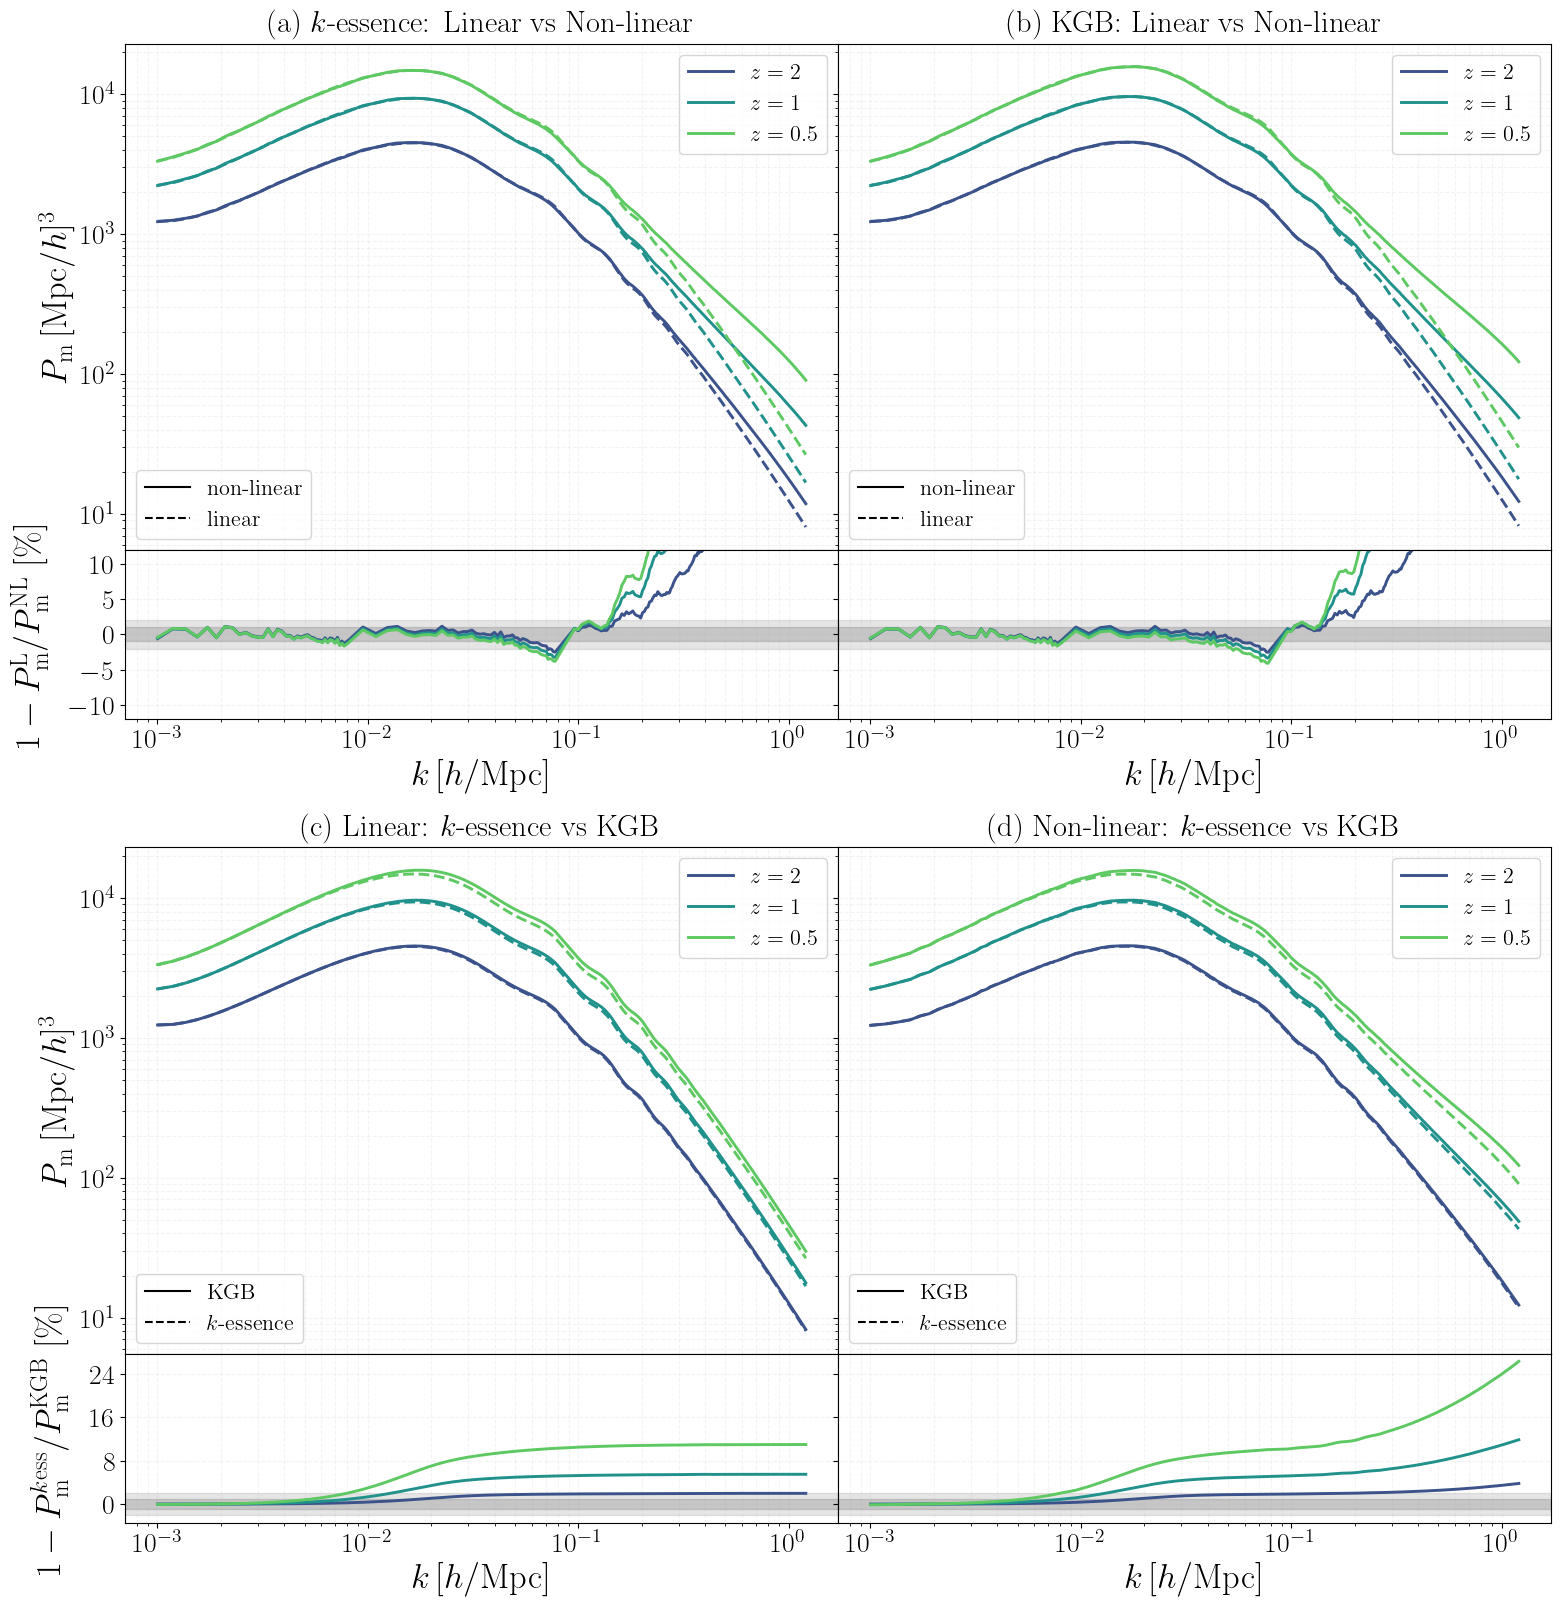

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# —————————————————————————————
# Assumes the following variables are already defined:
# k_zp, kk                  : wave number arrays (per redshift)
# Pk_m_kess_zp             : linear spectra for k-essence
# Pk_m_kgb_zp              : linear spectra for KGB
# delta_kess_zp            : nonlinear spectra (k-essence)
# delta_zp                 : nonlinear spectra (KGB)
# colors                   : color list for plotting
# show_sim_plots           : bool, use simulation k-values if True
# alpha_K_hat, alpha_B_hat : model params for plot titles
# target_z                 : list of redshifts [2, 1, 0]
# save_fig                 : function to save the figure
# —————————————————————————————


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}
colors = sns.color_palette("viridis", len(target_z)).as_hex()

# simulation
k_zp     = dict(zip(z, final['k']))
delta_zp = dict(zip(z, final['delta']))

# simulation kessence
delta_kess_zp = dict(zip(z, final_kess['delta']))


# hiclass
Pk_m_kgb_zp  = dict(zip(z, Pk_m_kgb))
Pk_m_kess_zp = dict(zip(z, Pk_m_kess))


# Set global plot styles
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Create figure
fig = plt.figure(figsize=(15.5, 17))

# Top-level 2x2 grid layout
outer_gs = GridSpec(
    nrows=2, ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    hspace=0.19,
    wspace=0.0
)

# Panel titles and data functions
panels = [
    (
        fr"(a) $k$‐essence: Linear vs Non-linear",
        lambda z: Pk_m_kess_zp[z],
        lambda z: delta_kess_zp[z]
    ),
    (
        fr"(b) KGB: Linear vs Non-linear",
        lambda z: Pk_m_kgb_zp[z],
        lambda z: delta_zp[z]
    ),
    (
        r"(c) Linear: $k$‐essence vs KGB",
        lambda z: Pk_m_kess_zp[z],
        lambda z: Pk_m_kgb_zp[z]
    ),
    (
        r"(d) Non‐linear: $k$‐essence vs KGB",
        lambda z: delta_kess_zp[z],
        lambda z: delta_zp[z]
    )
]

# Share y-axes within each row
shared_spec_axes = [None, None]
shared_diff_axes = [None, None]

# Loop over each of the 4 panels
for idx, (panel_title, get_P1, get_P2) in enumerate(panels):
    row = idx // 2
    col = idx % 2

    # Inner 2x1 layout for each panel (top: spectrum, bottom: diff)
    inner_gs = GridSpecFromSubplotSpec(
        nrows=2, ncols=1,
        height_ratios=[3, 1],
        hspace=0.0,
        subplot_spec=outer_gs[row, col]
    )

    # Top subplot: power spectrum
    if shared_spec_axes[row] is None:
        ax_spec = fig.add_subplot(inner_gs[0])
        shared_spec_axes[row] = ax_spec
    else:
        ax_spec = fig.add_subplot(inner_gs[0], sharey=shared_spec_axes[row])

    # Bottom subplot: relative difference
    if shared_diff_axes[row] is None:
        ax_diff = fig.add_subplot(inner_gs[1], sharex=ax_spec)
        shared_diff_axes[row] = ax_diff
    else:
        ax_diff = fig.add_subplot(inner_gs[1], sharex=ax_spec, sharey=shared_diff_axes[row])

    # Plot lines for each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val] if show_sim_plots else kk
        P1 = get_P1(z_val)
        P2 = get_P2(z_val)

        # Plot linear and nonlinear curves
        ax_spec.plot(k_vals, P1, '--', color=color, linewidth=2.1)
        ax_spec.plot(k_vals, P2, '-', label=rf"$z={z_val}$", color=color, linewidth=2.1)

        # Plot percent difference
        rel_diff = 100.0 * (1.0 - P1 / P2)
        ax_diff.plot(k_vals, rel_diff, '-', color=color, linewidth=2.1)

    # Formatting: top (spectrum)
    ax_spec.set_title(panel_title, fontsize=22, pad=8)
    ax_spec.set_xscale("log")
    ax_spec.set_yscale("log")
    ax_spec.grid(True, which="both", axis="both", linestyle="--", alpha=0.15)

    # Redshift legend (color lines)
    red_leg = ax_spec.legend(loc="upper right", fontsize=16)

    # Line style legend (dashed vs solid)
    handle_solid = Line2D([0], [0], linestyle='-', color='black')
    handle_dashed = Line2D([0], [0], linestyle='--', color='black')

    style_labels = (
        ["non-linear", "linear"] if idx < 2 else ["KGB", r"$k$-essence"]
    )

    ax_spec.legend(
        [handle_solid, handle_dashed],
        style_labels,
        loc="lower left",
        fontsize=16
    )
    ax_spec.add_artist(red_leg)

    # Formatting: bottom (difference)
    ax_diff.set_xscale("log")
    ax_diff.grid(True, which="both", axis="both", linestyle="--", alpha=0.15)
    ax_diff.axhspan(-1, 1, color="gray", alpha=0.3)
    ax_diff.axhspan(-2, 2, color="gray", alpha=0.2)
    ax_diff.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

    # ✳️ Set fixed y-limits only for first row (panels a and b)
    if row == 0:
        ax_diff.set_ylim(-12, 12)

    # Only bottom row gets x-axis label
    ax_diff.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # Y-axis labels only on left column
    if col == 0:
        ax_spec.set_ylabel(r"$P_{\mathrm{m}}\,[\mathrm{Mpc}/h]^3$", fontsize=25)
        ax_diff.set_ylabel(
            r"$1 - P_\mathrm{m}^\mathrm{L}/P_\mathrm{m}^\mathrm{NL}~[\%]$" if row == 0
            else r"$1 - P_\mathrm{m}^{k\mathrm{ess}}/P_\mathrm{m}^\mathrm{KGB}~[\%]$",
            fontsize=25,
            labelpad=15
        )
    else:
        ax_spec.tick_params(labelleft=False)
        ax_diff.tick_params(labelleft=False)

# Adjust final layout
fig.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.08)

# Save and show plot
save_fig("all_four_panels_2x2_corrected")
plt.show()

# $\Phi$ power spectrum

Saving figure phi_power_spectrum_2x2_layout


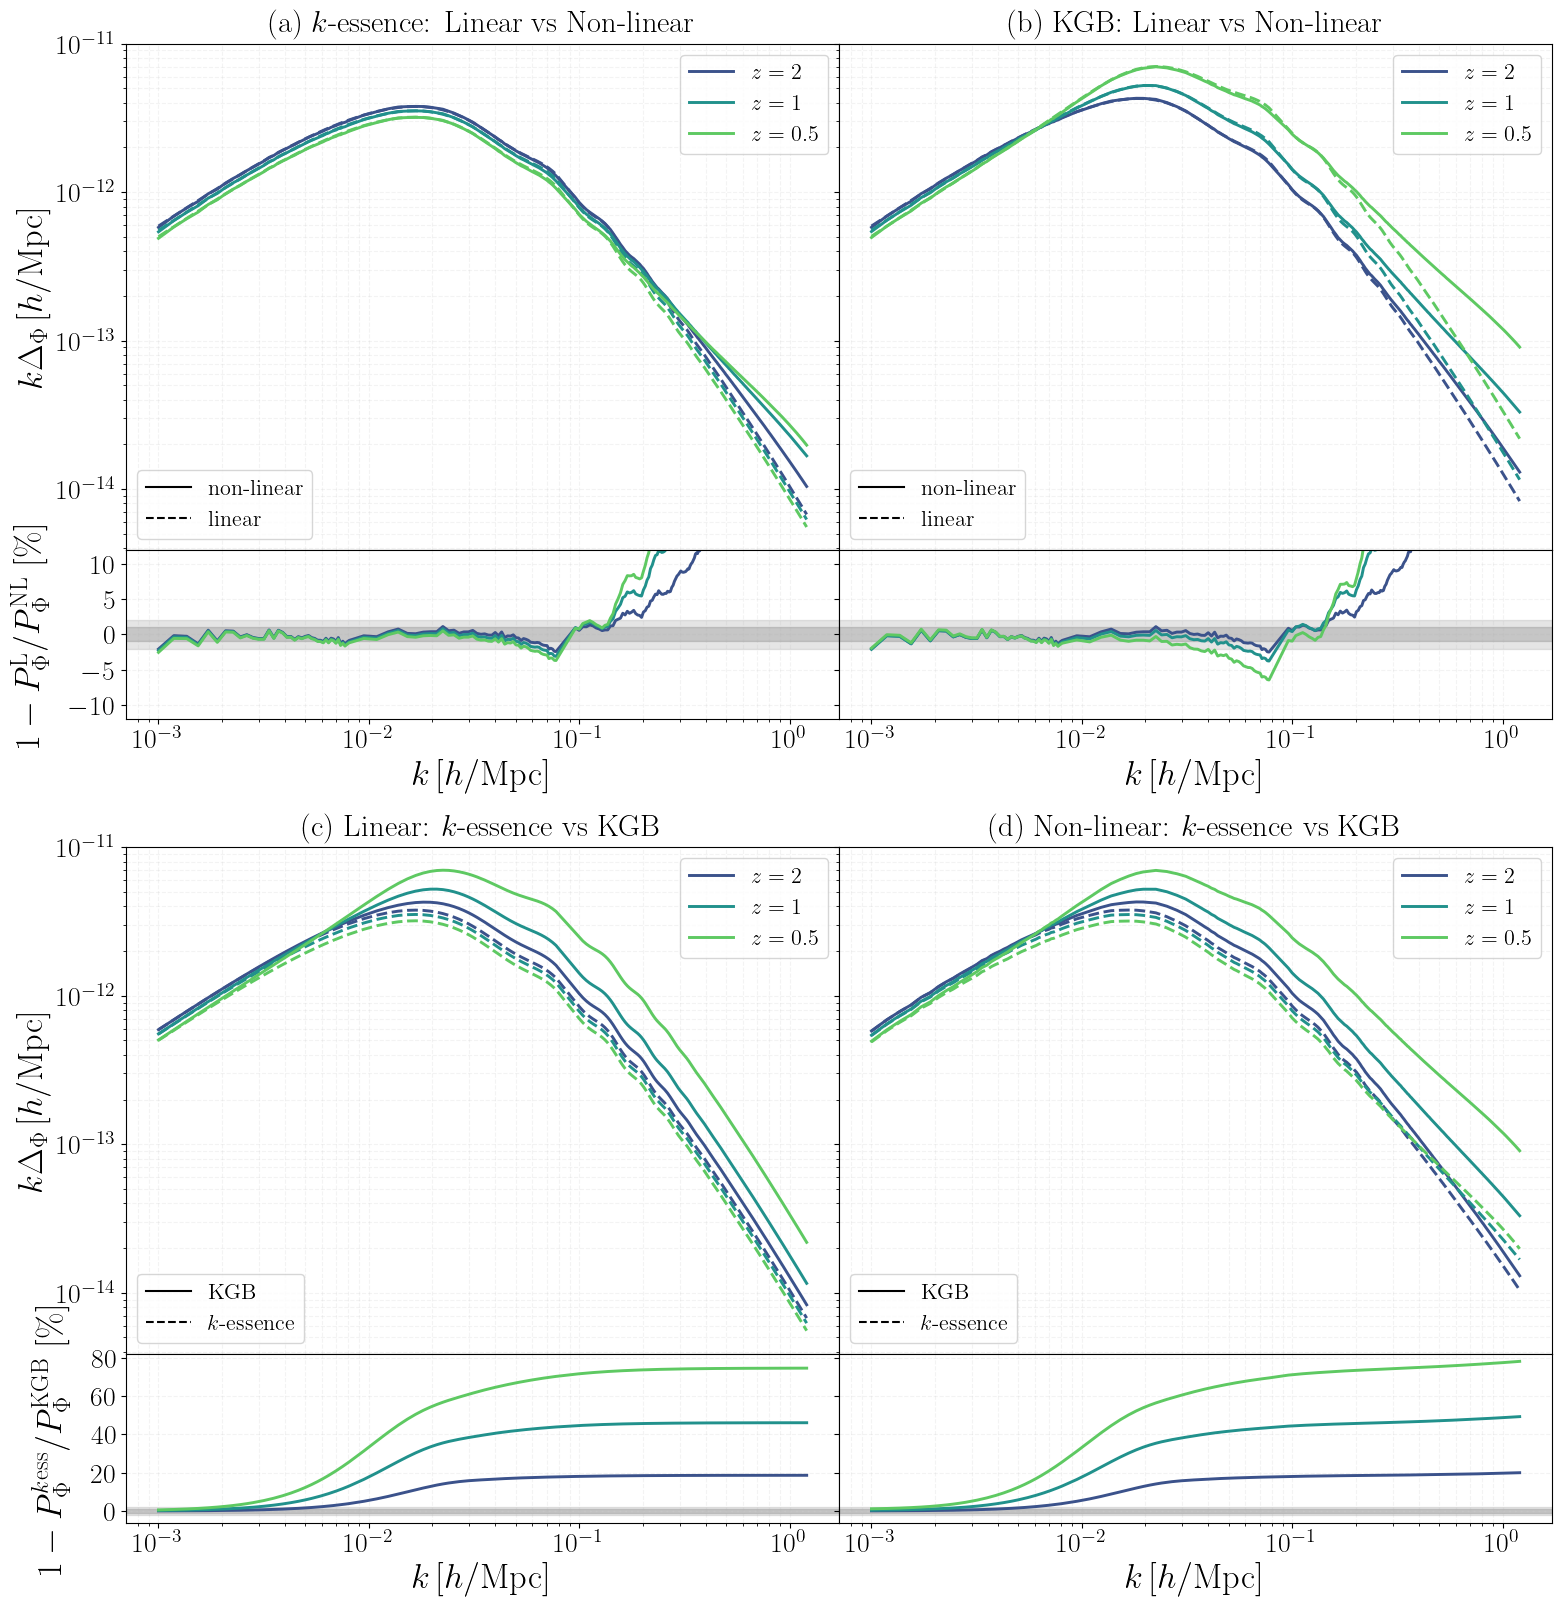

In [200]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# Global plot settings
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Create main figure
fig = plt.figure(figsize=(15.5, 17))
outer_gs = GridSpec(2, 2, hspace=0.19, wspace=0.0)


# simulation
k_zp     = dict(zip(z, final['k']))
phi_zp = dict(zip(z, final['phi']))

# simulation kessence
phi_kess_zp = dict(zip(z, final_kess['phi']))


# hiclass
Pk_phi_kgb_zp  = dict(zip(z, Pk_phi_kgb))
Pk_phi_kess_zp = dict(zip(z, Pk_phi_kess))


# Helper functions to fetch data per redshift
def get_phi_kess(z): return Pk_phi_kess_zp[z]
def get_phi_kgb(z): return Pk_phi_kgb_zp[z]
def get_phi_kess_sim(z): return k_zp[z] * h * phi_kess_zp[z]
def get_phi_kgb_sim(z): return k_zp[z] * h * phi_zp[z]

# Panels to display
panels = [
    (
        fr"(a) $k$‐essence: Linear vs Non-linear",
        get_phi_kess, get_phi_kess_sim
    ),
    (
        fr"(b) KGB: Linear vs Non-linear",
        get_phi_kgb, get_phi_kgb_sim
    ),
    (
        r"(c) Linear: $k$‐essence vs KGB",
        get_phi_kess, get_phi_kgb
    ),
    (
        r"(d) Non-linear: $k$‐essence vs KGB",
        get_phi_kess_sim, get_phi_kgb_sim
    )
]

# Share axes setup
shared_spec_axes = [None, None]
shared_diff_axes = [None, None]

# Plot loop
for idx, (title, get_P1, get_P2) in enumerate(panels):
    row, col = divmod(idx, 2)

    inner_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3, 1], hspace=0.0, subplot_spec=outer_gs[row, col])
    
    ax_spec = fig.add_subplot(inner_gs[0], sharey=shared_spec_axes[row]) if shared_spec_axes[row] is None else fig.add_subplot(inner_gs[0], sharey=shared_spec_axes[row])
    ax_diff = fig.add_subplot(inner_gs[1], sharex=ax_spec, sharey=shared_diff_axes[row]) if shared_diff_axes[row] is None else fig.add_subplot(inner_gs[1], sharex=ax_spec, sharey=shared_diff_axes[row])
    shared_spec_axes[row] = ax_spec
    shared_diff_axes[row] = ax_diff

    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P1 = get_P1(z_val)
        P2 = get_P2(z_val)

        ax_spec.plot(k_vals, P1, "--", color=color, linewidth=2.1)
        ax_spec.plot(k_vals, P2, "-", label=rf"$z={z_val}$", color=color, linewidth=2.1)

        rel_diff = 100.0 * (1.0 - np.array(P1) / np.array(P2))
        ax_diff.plot(k_vals, rel_diff, "-", color=color, linewidth=2.1)

    # Title and formatting
    ax_spec.set_title(title, fontsize=22, pad=8)
    ax_spec.set_xscale("log")
    ax_spec.set_yscale("log")
    ax_spec.grid(True, which="both", axis="both", linestyle="--", alpha=0.15)

    # Legends
    red_leg = ax_spec.legend(loc="upper right", fontsize=16)
    handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = (
        ["non-linear", "linear"] if idx < 2 else ["KGB", r"$k$-essence"]
    )
    ax_spec.legend(handles, style_labels, loc="lower left", fontsize=16)
    ax_spec.add_artist(red_leg)

    # Difference panel
    ax_diff.set_xscale("log")
    ax_diff.grid(True, which="both", axis="both", linestyle="--", alpha=0.15)
    ax_diff.axhspan(-1, 1, color="gray", alpha=0.3)
    ax_diff.axhspan(-2, 2, color="gray", alpha=0.2)
    ax_diff.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

    if row == 0:
        ax_diff.set_ylim(-12, 12)

    ax_diff.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    if col == 0:
        ax_spec.set_ylabel(r"$k\Delta_\Phi \,[h/\mathrm{Mpc}]$", fontsize=25)
        ax_diff.set_ylabel(
            r"$1 - P_{\Phi}^\mathrm{L}/P_{\Phi}^\mathrm{NL}~[\%]$" if row == 0
            else r"$1 - P_{\Phi}^{k\mathrm{ess}}/P_\Phi^\mathrm{KGB}~[\%]$",
            fontsize=25,
            labelpad=15
        )
    else:
        ax_spec.tick_params(labelleft=False)
        ax_diff.tick_params(labelleft=False)

# Adjust layout and save
fig.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.08)
save_fig("phi_power_spectrum_2x2_layout")
plt.show()


# Dark energy power spectrum

Saving figure dark_energy_power_spectrum


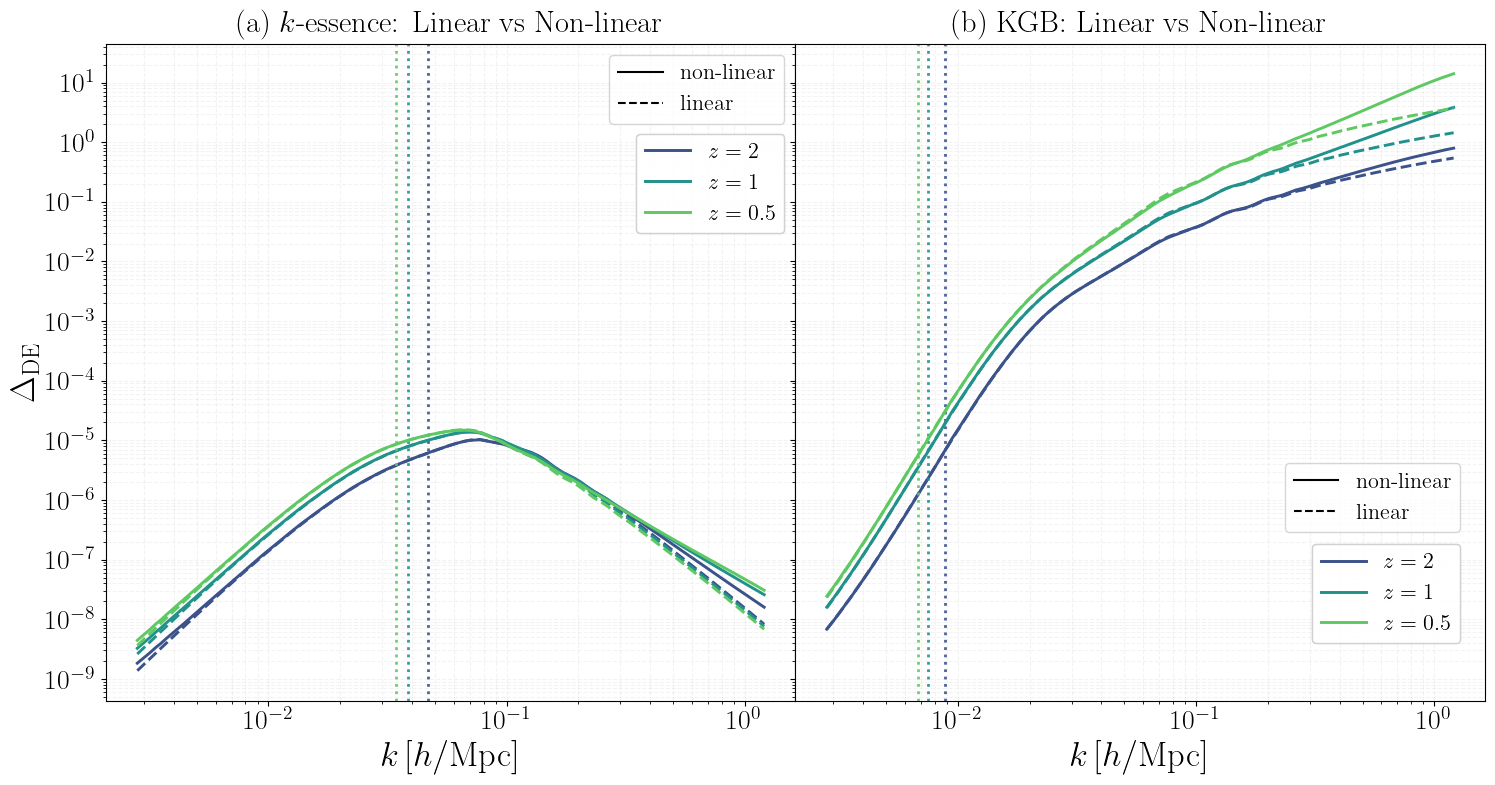

In [208]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns

# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z, final_kess['delta_kgb']))
Pk_smg_kgb_zp  = dict(zip(z, Pk_smg_kgb))
Pk_smg_kess_zp = dict(zip(z, Pk_smg_kess))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence: Linear vs Non-linear",
        lambda zz: Pk_smg_kess_zp[zz],
        lambda zz: delta_kess_zp[zz],
        k_kess_dict
    ),
    (
        r"(b) KGB: Linear vs Non-linear",
        lambda zz: Pk_smg_kgb_zp[zz],
        lambda zz: delta_kgb_zp[zz],
        k_kgb_dict
    )
]

start_ind = 10

for i, (ax, (title, get_lin, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_lin  = get_lin(z_val)
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]

        ax.plot(k_vals[start_ind:], P_lin[start_ind:], "--",
                color=color, linewidth=2.1)
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
        ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    
    ax.yaxis.set_minor_locator(
    LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax.yaxis.set_major_locator(LogLocator(numticks=15))
    
    if i == 0:
        ax.set_ylabel(r"$\Delta_\mathrm{DE}$", fontsize=25)

    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel
    if i == 1:
        # Bottom‐right corner inside axes, with style legend just above redshift legend
        style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
        red_bbox   = (0.98, 0.07)
        style_loc  = "lower right"
        red_loc    = "lower right"
    else:
        # k-essence: style at upper left, redshift just below
        style_bbox = None
        red_bbox   = (1, 0.88)
        style_loc  = "upper right"
        red_loc    = "upper right"

    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("dark_energy_power_spectrum")
plt.show()


# ratio $\frac{\Delta_\mathrm{DE}}{\Delta_\mathrm{m}}$

Saving figure ratio_DE_m


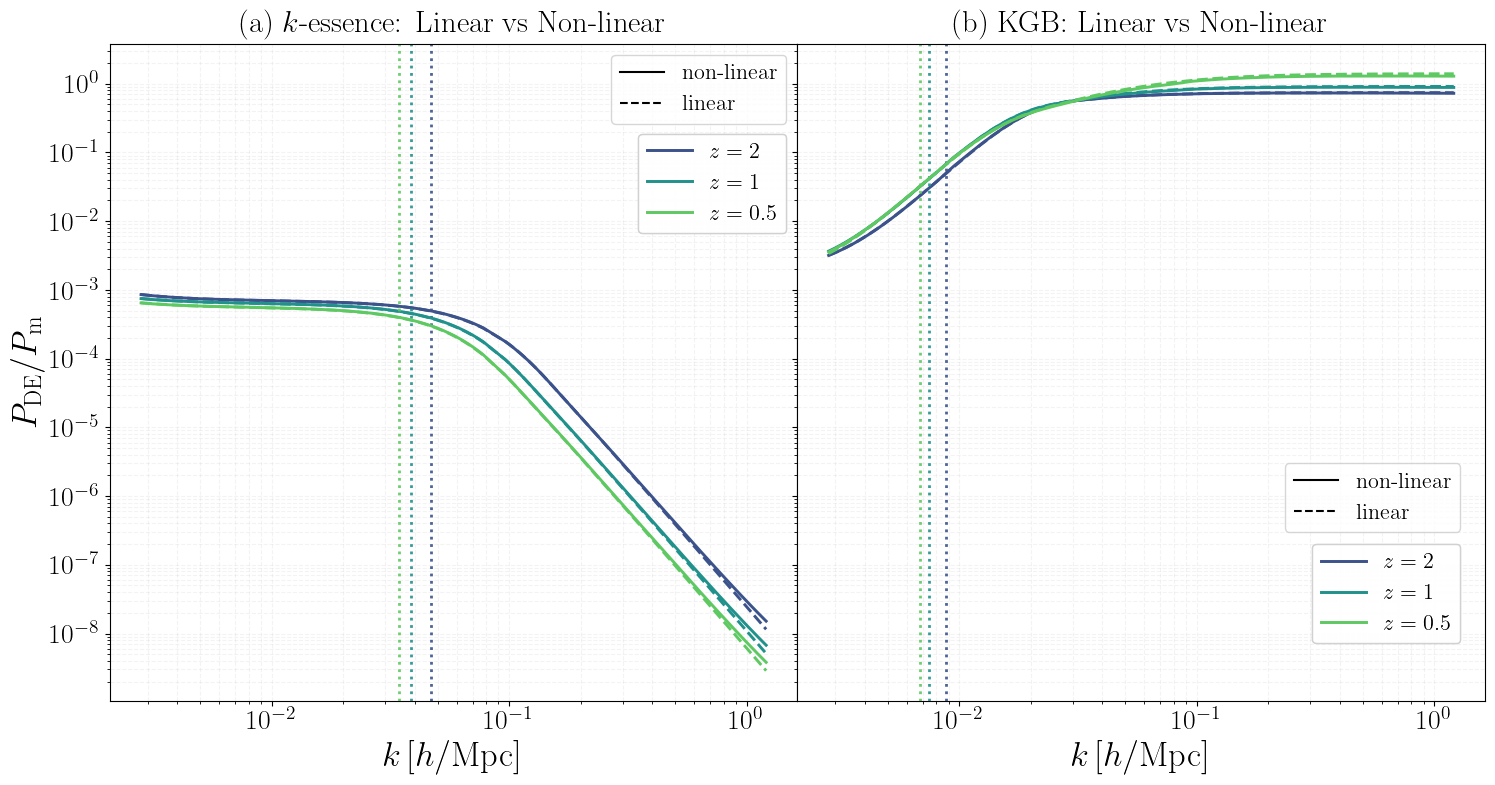

In [195]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns

# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
# dark energy
k_zp           = dict(zip(z, final['k']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z, final_kess['delta_kgb']))
Pk_smg_kgb_zp  = dict(zip(z, Pk_smg_kgb))
Pk_smg_kess_zp = dict(zip(z, Pk_smg_kess))

# matter
delta_m_kgb_zp = dict(zip(z, final['delta_unnorm']))
delta_m_kess_zp = dict(zip(z, final_kess['delta_unnorm']))
Pk_m_kgb_zp  = dict(zip(z, Pk_m_kgb_unnorm))
Pk_m_kess_zp = dict(zip(z, Pk_m_kess_unnorm))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence: Linear vs Non-linear",
        lambda zz: Pk_smg_kess_zp[zz] / Pk_m_kess_zp[zz],
        lambda zz: delta_kess_zp[zz] / delta_m_kess_zp [zz],
        k_kess_dict
    ),
    (
        r"(b) KGB: Linear vs Non-linear",
        lambda zz: Pk_smg_kgb_zp[zz] / Pk_m_kgb_zp[zz],
        lambda zz: delta_kgb_zp[zz] / delta_m_kgb_zp [zz],
        k_kgb_dict
    )
]

start_ind = 10

for i, (ax, (title, get_lin, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_lin  = get_lin(z_val)
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]

        ax.plot(k_vals[start_ind:], P_lin[start_ind:], "--",
                color=color, linewidth=2.1)
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
        ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    
    ax.yaxis.set_minor_locator(
    LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax.yaxis.set_major_locator(LogLocator(numticks=15))
    
    if i == 0:
        ax.set_ylabel(r"$P_\mathrm{DE}/P_\mathrm{m}$", fontsize=25)

    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel
    if i == 1:
        # Bottom‐right corner inside axes, with style legend just above redshift legend
        style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
        red_bbox   = (0.98, 0.07)
        style_loc  = "lower right"
        red_loc    = "lower right"
    else:
        # k-essence: style at upper left, redshift just below
        style_bbox = None
        red_bbox   = (1, 0.88)
        style_loc  = "upper right"
        red_loc    = "upper right"

    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("ratio_DE_m")
plt.show()

# $\Delta_{{\rm DE}\times {\rm m}}$ cross correlation

Saving figure cross_DE_m


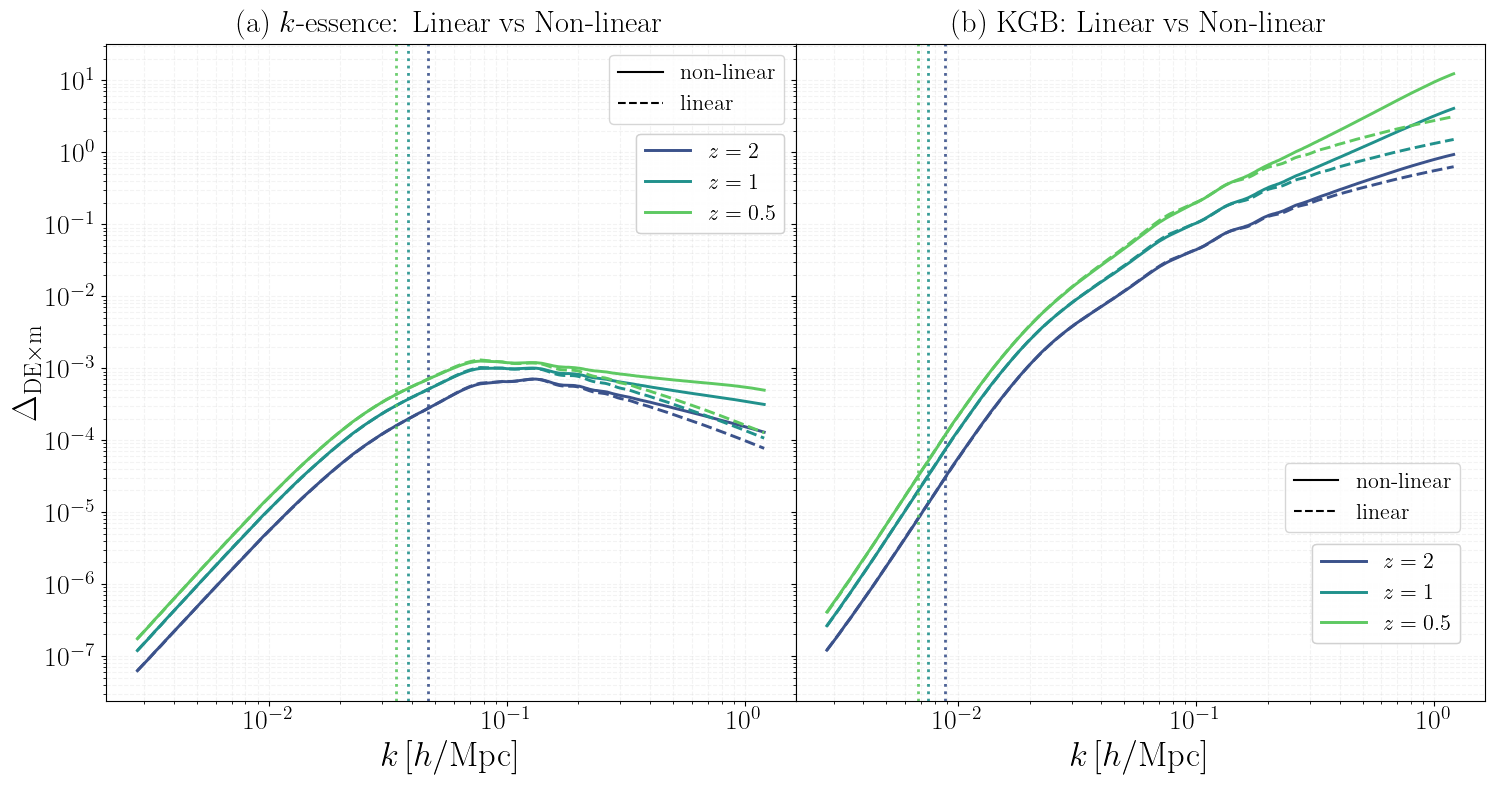

In [196]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns




# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
# KGB
k_zp           = dict(zip(z, final['k']))
Pk_smg_m_kgb_zp  = dict(zip(z, Pk_smg_m_kgb))
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))


# kess
Pk_smg_m_kess_zp  = dict(zip(z, Pk_smg_m_kess))
deltakess_deltam_zp = dict(zip(z, final_kess['deltakgb_deltam']))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence: Linear vs Non-linear",
        lambda zz: Pk_smg_m_kess_zp[zz],
        lambda zz: deltakess_deltam_zp[zz] ,
        k_kess_dict
    ),
    (
        r"(b) KGB: Linear vs Non-linear",
        lambda zz: Pk_smg_m_kgb_zp[zz],
        lambda zz: deltakgb_deltam_zp[zz],
        k_kgb_dict
    )
]

start_ind = 10

for i, (ax, (title, get_lin, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_lin  = get_lin(z_val)
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]
        
        ax.plot(k_vals[start_ind:], P_lin[start_ind:], "--",
                color=color, linewidth=2.1)
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
        ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.yaxis.set_minor_locator(
    LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax.yaxis.set_major_locator(LogLocator(numticks=15))
      
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    if i == 0:
        ax.set_ylabel(r"$\Delta_{\mathrm{DE}\times{\mathrm{m}}}$", fontsize=25)

    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel
    if i == 1:
        # Bottom‐right corner inside axes, with style legend just above redshift legend
        style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
        red_bbox   = (0.98, 0.07)
        style_loc  = "lower right"
        red_loc    = "lower right"
    else:
        # k-essence: style at upper left, redshift just below
        style_bbox = None
        red_bbox   = (1, 0.88)
        style_loc  = "upper right"
        red_loc    = "upper right"

    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("cross_DE_m")
plt.show()

# $\Delta_X$ normalized cross power spectra

Saving figure norm_cross_DE_m


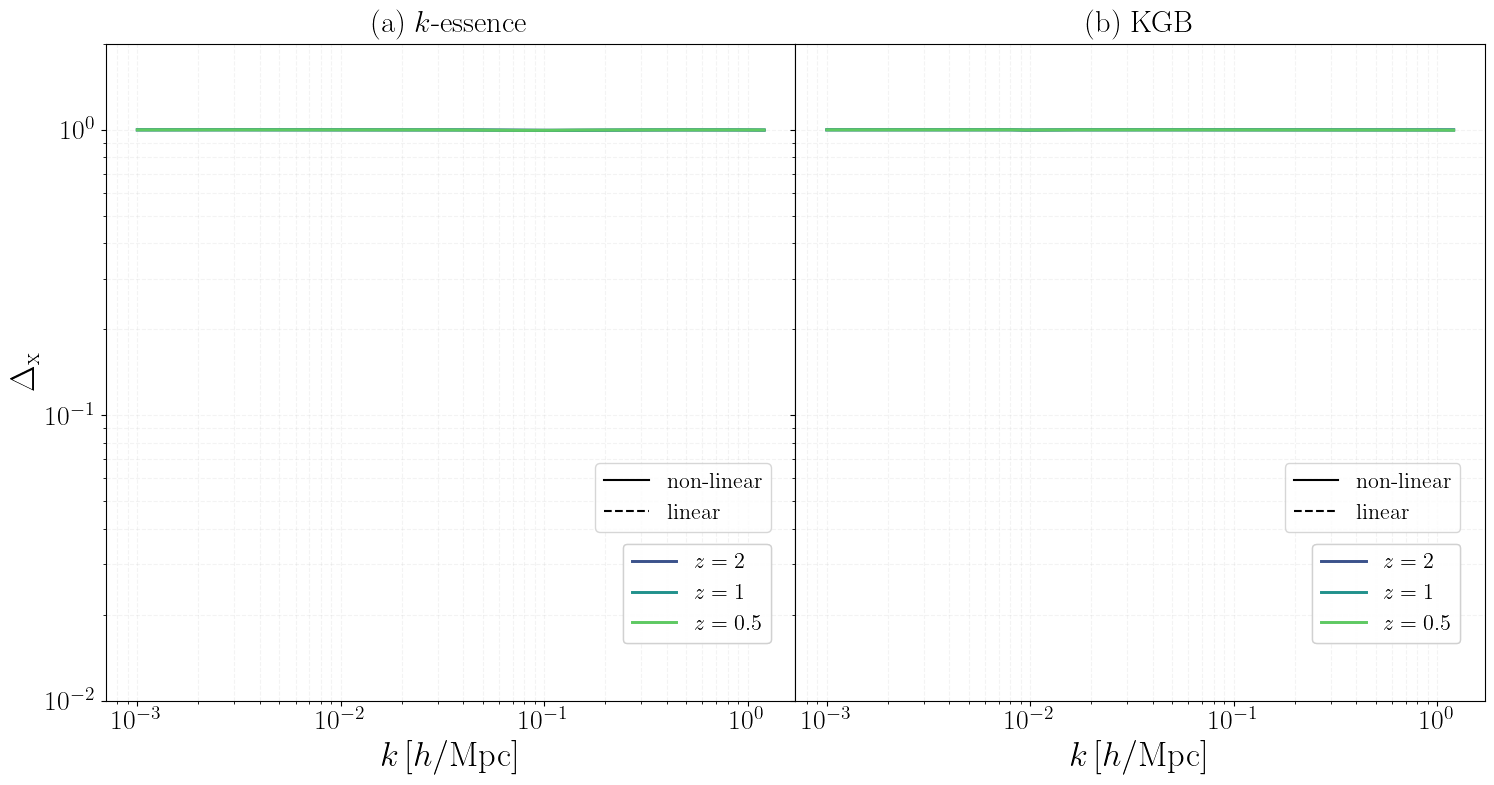

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns




# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
# KGB
k_zp           = dict(zip(z, final['k']))
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_m_kgb_zp = dict(zip(z, final['delta_unnorm']))

# kess
k_kess_zp           = dict(zip(z, final_kess['k']))
deltakess_deltam_zp = dict(zip(z, final_kess['deltakgb_deltam']))
delta_kess_zp  = dict(zip(z, final_kess['delta_kgb']))
delta_m_kess_zp = dict(zip(z, final_kess['delta_unnorm']))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence",
        lambda zz: deltakess_deltam_zp[zz]/(np.sqrt(delta_kess_zp[zz]*delta_m_kess_zp[zz])) ,

        k_kess_dict
    ),
    (
        r"(b) KGB",
        lambda zz: deltakgb_deltam_zp[zz]/(np.sqrt(delta_kgb_zp[zz]*delta_m_kgb_zp[zz])),
        k_kgb_dict
    )
]

start_ind = 0

for i, (ax, (title, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_kess_zp[z_val]
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]
        
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
#         ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
#     ax.yaxis.set_minor_locator(
#     LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
#     ax.yaxis.set_major_locator(LogLocator(numticks=15))
      
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    if i == 0:
        ax.set_ylabel(r"$\Delta_\mathrm{x}$", fontsize=25)
        
    ax.set_ylim(1e-2,2e0)
    ax.yaxis.set_major_locator(LogLocator(
    base=10.0,
    subs=(1.0,),    # only at 1×10^n
    numticks=10     # roughly one tick per decade
))
#     ax.set_yticks(np.linspace(0,1,6))        # majors at 0.,0.2,…,1.0
#     ax.set_yticks(np.linspace(0,1,11), minor=True)
#     ax.minorticks_on()
    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel

    # Bottom‐right corner inside axes, with style legend just above redshift legend
    style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
    red_bbox   = (0.98, 0.07)
    style_loc  = "lower right"
    red_loc    = "lower right"


    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("norm_cross_DE_m")
plt.show()

# $\pi$  power spectrum

Saving figure pi


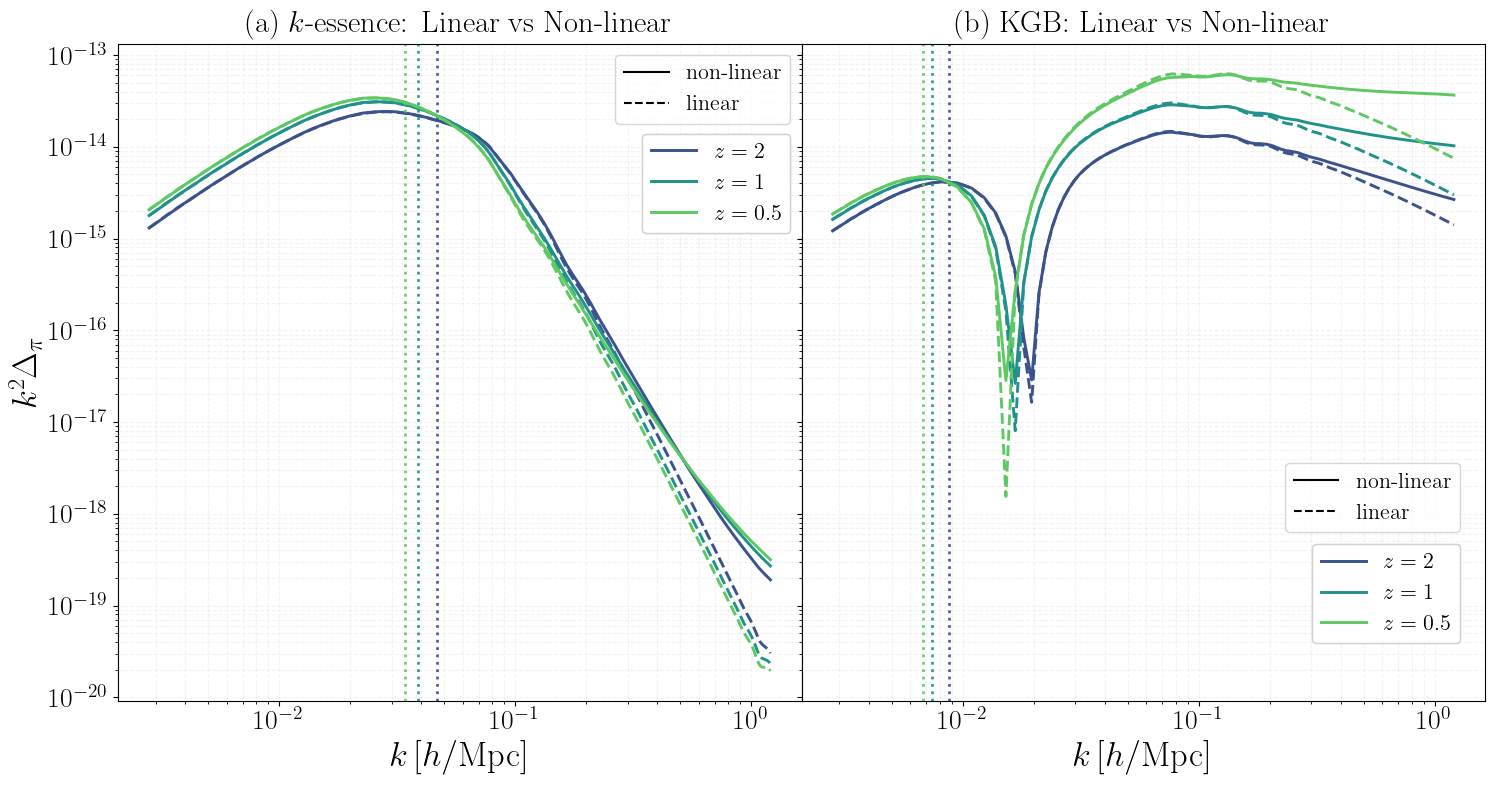

In [197]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns

# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===

# simulation
k_zp     = dict(zip(z, final['k']))
pi_k_zp = dict(zip(z, final['pi_k']))

# simulation kessence
pi_k_kess_zp = dict(zip(z, final_kess['pi_k']))


# hiclass
Pk_pi_k_kgb_zp  = dict(zip(z, Pk_pi_k_kgb))
Pk_pi_k_kess_zp = dict(zip(z, Pk_pi_k_kess))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence: Linear vs Non-linear",
        lambda zz: Pk_pi_k_kess_zp[zz] ,
        lambda zz: pi_k_kess_zp[zz],
        k_kess_dict
    ),
    (
        r"(b) KGB: Linear vs Non-linear",
        lambda zz: Pk_pi_k_kgb_zp[zz] ,
        lambda zz: pi_k_zp[zz] ,
        k_kgb_dict
    )
]

start_ind = 10

for i, (ax, (title, get_lin, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_lin  = get_lin(z_val)
        P_nl   = ((k_vals*h)**2)*get_nl(z_val)
        k_sh   = k_dict[z_val]

        ax.plot(k_vals[start_ind:], P_lin[start_ind:], "--",
                color=color, linewidth=2.1)
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
        ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    
    ax.yaxis.set_minor_locator(
    LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax.yaxis.set_major_locator(LogLocator(numticks=15))
    
    if i == 0:
        ax.set_ylabel(r"$k^2\Delta_{\pi}$", fontsize=25)

    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel
    if i == 1:
        # Bottom‐right corner inside axes, with style legend just above redshift legend
        style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
        red_bbox   = (0.98, 0.07)
        style_loc  = "lower right"
        red_loc    = "lower right"
    else:
        # k-essence: style at upper left, redshift just below
        style_bbox = None
        red_bbox   = (1, 0.88)
        style_loc  = "upper right"
        red_loc    = "upper right"

    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("pi")
plt.show()

# $\zeta$ power spectrum

Saving figure zeta


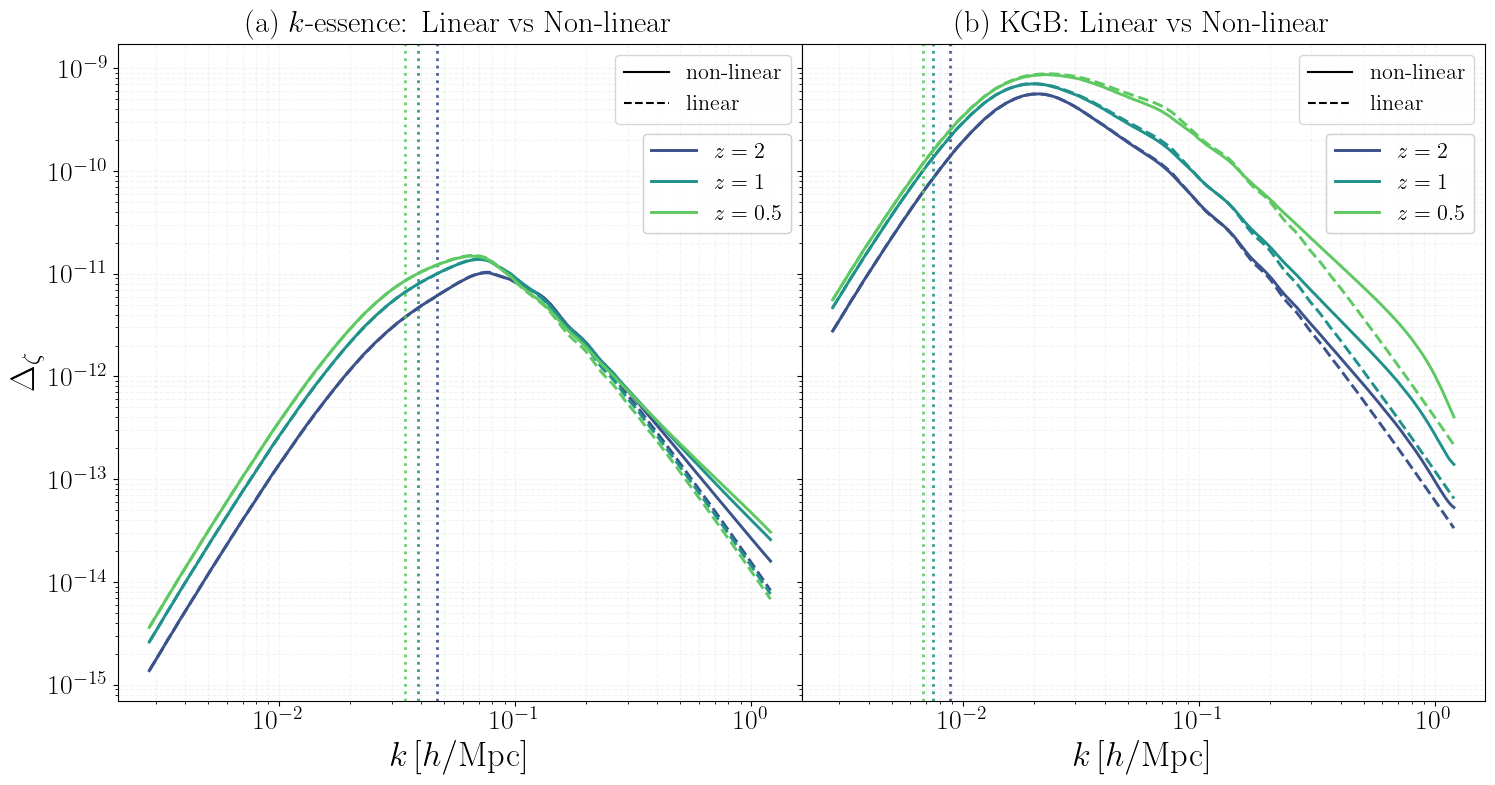

In [198]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns

# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
# simulation
k_zp     = dict(zip(z, final['k']))
zeta_zp = dict(zip(z, final['zeta']))

# simulation kessence
zeta_kess_zp = dict(zip(z, final_kess['zeta']))


# hiclass
Pk_zeta_kgb_zp  = dict(zip(z, Pk_zeta_kgb))
Pk_zeta_kess_zp = dict(zip(z, Pk_zeta_kess))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence: Linear vs Non-linear",
        lambda zz: Pk_zeta_kess_zp[zz] ,
        lambda zz: zeta_kess_zp[zz],
        k_kess_dict
    ),
    (
        r"(b) KGB: Linear vs Non-linear",
        lambda zz: Pk_zeta_kgb_zp[zz] ,
        lambda zz: zeta_zp[zz] ,
        k_kgb_dict
    )
]

start_ind = 10

for i, (ax, (title, get_lin, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_lin  = get_lin(z_val)
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]

        ax.plot(k_vals[start_ind:], P_lin[start_ind:], "--",
                color=color, linewidth=2.1)
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
        ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    
    ax.yaxis.set_minor_locator(
    LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax.yaxis.set_major_locator(LogLocator(numticks=15))
    
    if i == 0:
        ax.set_ylabel(r"$\Delta_{\zeta}$", fontsize=25)

    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel
#     if i == 1:
#         # Bottom‐right corner inside axes, with style legend just above redshift legend
#         style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
#         red_bbox   = (0.98, 0.07)
#         style_loc  = "lower right"
#         red_loc    = "lower right"
#     else:
    # k-essence: style at upper left, redshift just below
    style_bbox = None
    red_bbox   = (1, 0.88)
    style_loc  = "upper right"
    red_loc    = "upper right"

    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("zeta")
plt.show()

# $\Phi'$ power spectrum

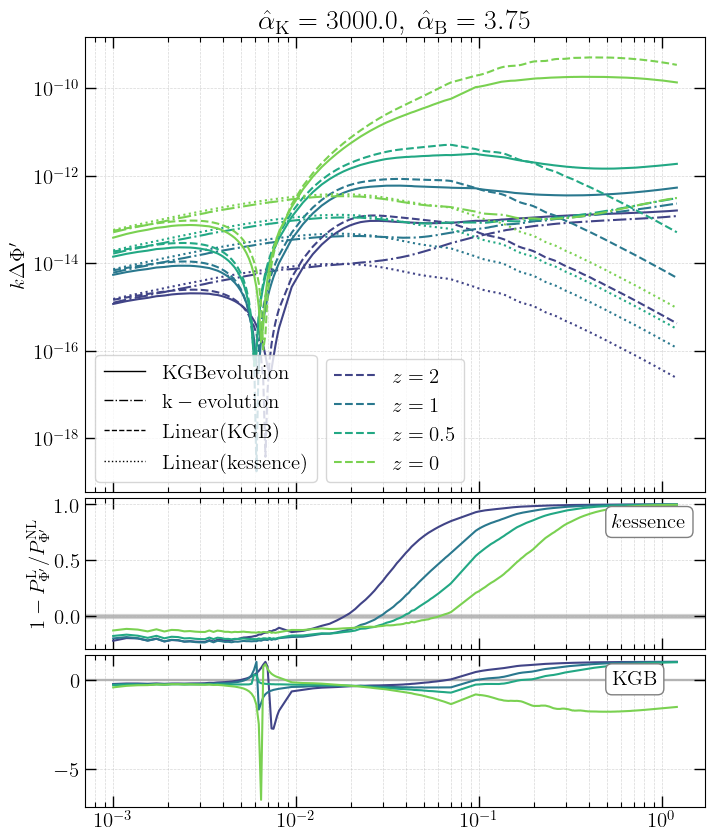

In [147]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
phi_prime_zp = dict(zip(z, final['phi_prime']))

# simulation kessence
phi_prime_kess_zp = dict(zip(z, final_kess['phi_prime']))


# hiclass
Pk_phi_prime_kgb_zp  = dict(zip(z, Pk_phi_prime_kgb))
Pk_phi_prime_kess_zp = dict(zip(z, Pk_phi_prime_kess))




colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    phi_prime_vals = k_vals*h*phi_prime_zp[zv]
    phi_prime_kess_vals = k_vals*h*phi_prime_kess_zp[zv]
    
    # hiclass
    Pk_phi_prime_kgb_vals = Pk_phi_prime_kgb_zp[zv]
    Pk_phi_prime_kess_vals = Pk_phi_prime_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        
        ax[0].plot(
            k_vals,
            phi_prime_kess_vals,"-.",
            c = c,
            alpha =1,
            markersize=6
        )
    
        ax[0].plot(
            k_vals,
            phi_prime_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
    
    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_phi_prime_kess_vals)/phi_prime_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_phi_prime_kgb_vals)/phi_prime_vals),"-",
        c = c,
        markersize=6
    )


    
    
linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range (1,3):
    #ax[i].set_ylim(-0.2,0.2)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$k\Delta\Phi'$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\Phi'}^\mathrm{L}/P_{\Phi'}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="lower center",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\pi$ power spectra

# $\zeta$ power spectra

# $\mu$ function

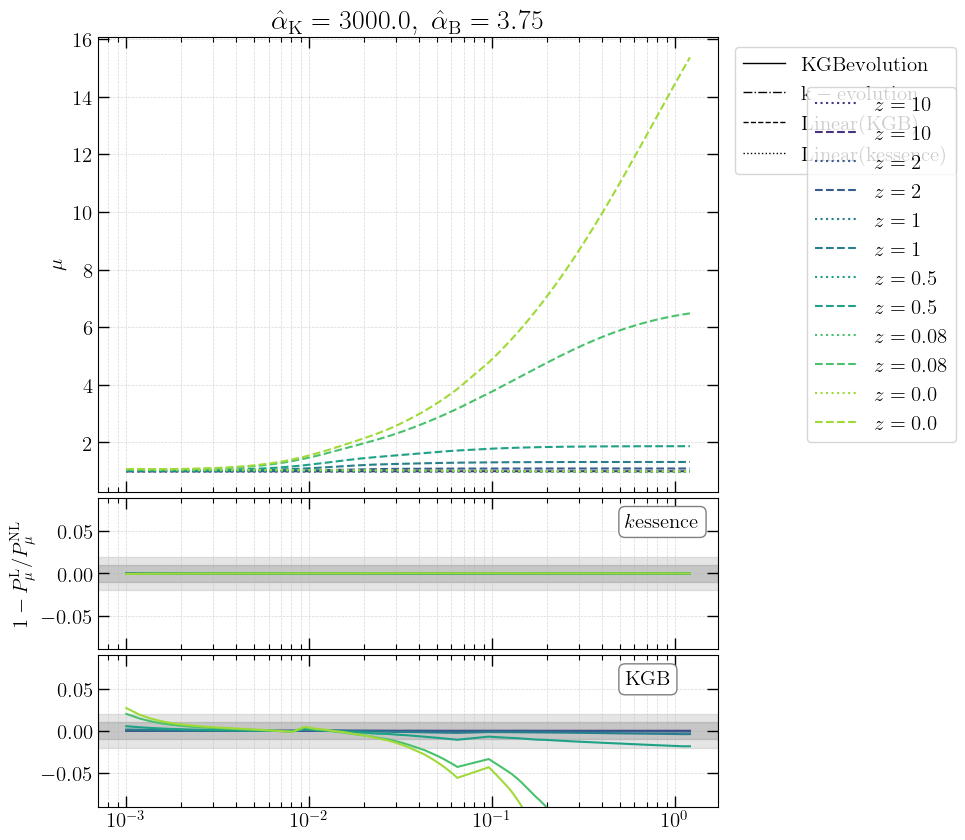

In [10]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation KGB
k_zp     = dict(zip(z, final['k']))
mu_kgb_zp = dict(zip(z, final['mu']))


# simulation kessence
mu_kess_zp = dict(zip(z, final_kess['mu']))


# hiclass
Pk_mu_kgb_zp  = dict(zip(z, mu_kgb))
Pk_mu_kess_zp = dict(zip(z, mu_kess))



colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    mu_kgb_vals = mu_kgb_zp[zv]
    mu_kess_vals = mu_kess_zp[zv]
    
    # hiclass
    Pk_mu_kgb_vals = Pk_mu_kgb_zp[zv]
    Pk_mu_kess_vals = Pk_mu_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_mu_kess_vals,":",
        label=f"$z={zv}$",
        c = c,
        markersize=6
    )
    
    ax[0].plot(
        k_vals,
        Pk_mu_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    

    
    
    #############################################################################
    #                                         KGB-evolution
    
#     if show_sim_plots:
        
#         ax[0].plot(
#             k_vals,
#             mu_kess_vals,"-.",
#             c = c,
#             alpha =1,
#             markersize=6
#         )
        
#         ax[0].plot(
#             k_vals,
#             mu_kgb_vals,"-",
#             c = c,
#             alpha =1,
#             markersize=6
#         )

    
    
    
    
#     ##############################################################################
#     #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_mu_kess_vals)/mu_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_mu_kgb_vals)/mu_kgb_vals),"-",
        c = c,
        markersize=6
    )
    


    
    

linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="upper right",  bbox_to_anchor=(1.4, 1.0), fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
#ax[0].set_ylim(1,10)    

for i in range (1,3):
    ax[i].set_ylim(-0.09,0.09)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    


    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


#ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\mu$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\mu}^\mathrm{L}/P_{\mu}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="center right",  # Place legend above the plot
    bbox_to_anchor=(1.4, 0.5)
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# Snapshots

In [157]:
import h5py

snap_path = "/home/ahmad/kgb-master/data/snapshots/"

import h5py
import glob

# Define filename patterns for dark energy and matter snapshots
dark_pattern = snap_path +'/snap_*_T00_kgb.h5'
matter_pattern = snap_path+ '/snap_*_T00.h5'

# Collect and sort matching file paths
dark_files = sorted(glob.glob(dark_pattern))
matter_files = sorted(glob.glob(matter_pattern))

# Exclude any dark-energy files from the matter list just in case
matter_files = [f for f in matter_files if '_kgb' not in f]

# Open HDF5 files and store file objects in separate lists
dark_snapshots = [h5py.File(f, 'r') for f in dark_files]
matter_snapshots = [h5py.File(f, 'r') for f in matter_files]

# Example: Access a dataset from the first dark energy snapshot
# coords_dark = dark_snapshots[0]['PartType1/Coordinates'][:]
# coords_matter = matter_snapshots[0]['PartType1/Coordinates'][:]

# When you're done processing, remember to close all files:
# for f in dark_snapshots + matter_snapshots:
#     f.close()

print("Dark energy files loaded:", dark_files)
print("Matter files loaded:", matter_files)

Dark energy files loaded: ['/home/ahmad/kgb-master/data/snapshots/snap_000_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_001_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_002_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_003_T00_kgb.h5']
Matter files loaded: ['/home/ahmad/kgb-master/data/snapshots/snap_000_T00.h5', '/home/ahmad/kgb-master/data/snapshots/snap_001_T00.h5', '/home/ahmad/kgb-master/data/snapshots/snap_002_T00.h5', '/home/ahmad/kgb-master/data/snapshots/snap_003_T00.h5']


In [164]:
 matter_snapshots[0]['data']

<HDF5 dataset "data": shape (1200, 1200, 1200), type "<f8">

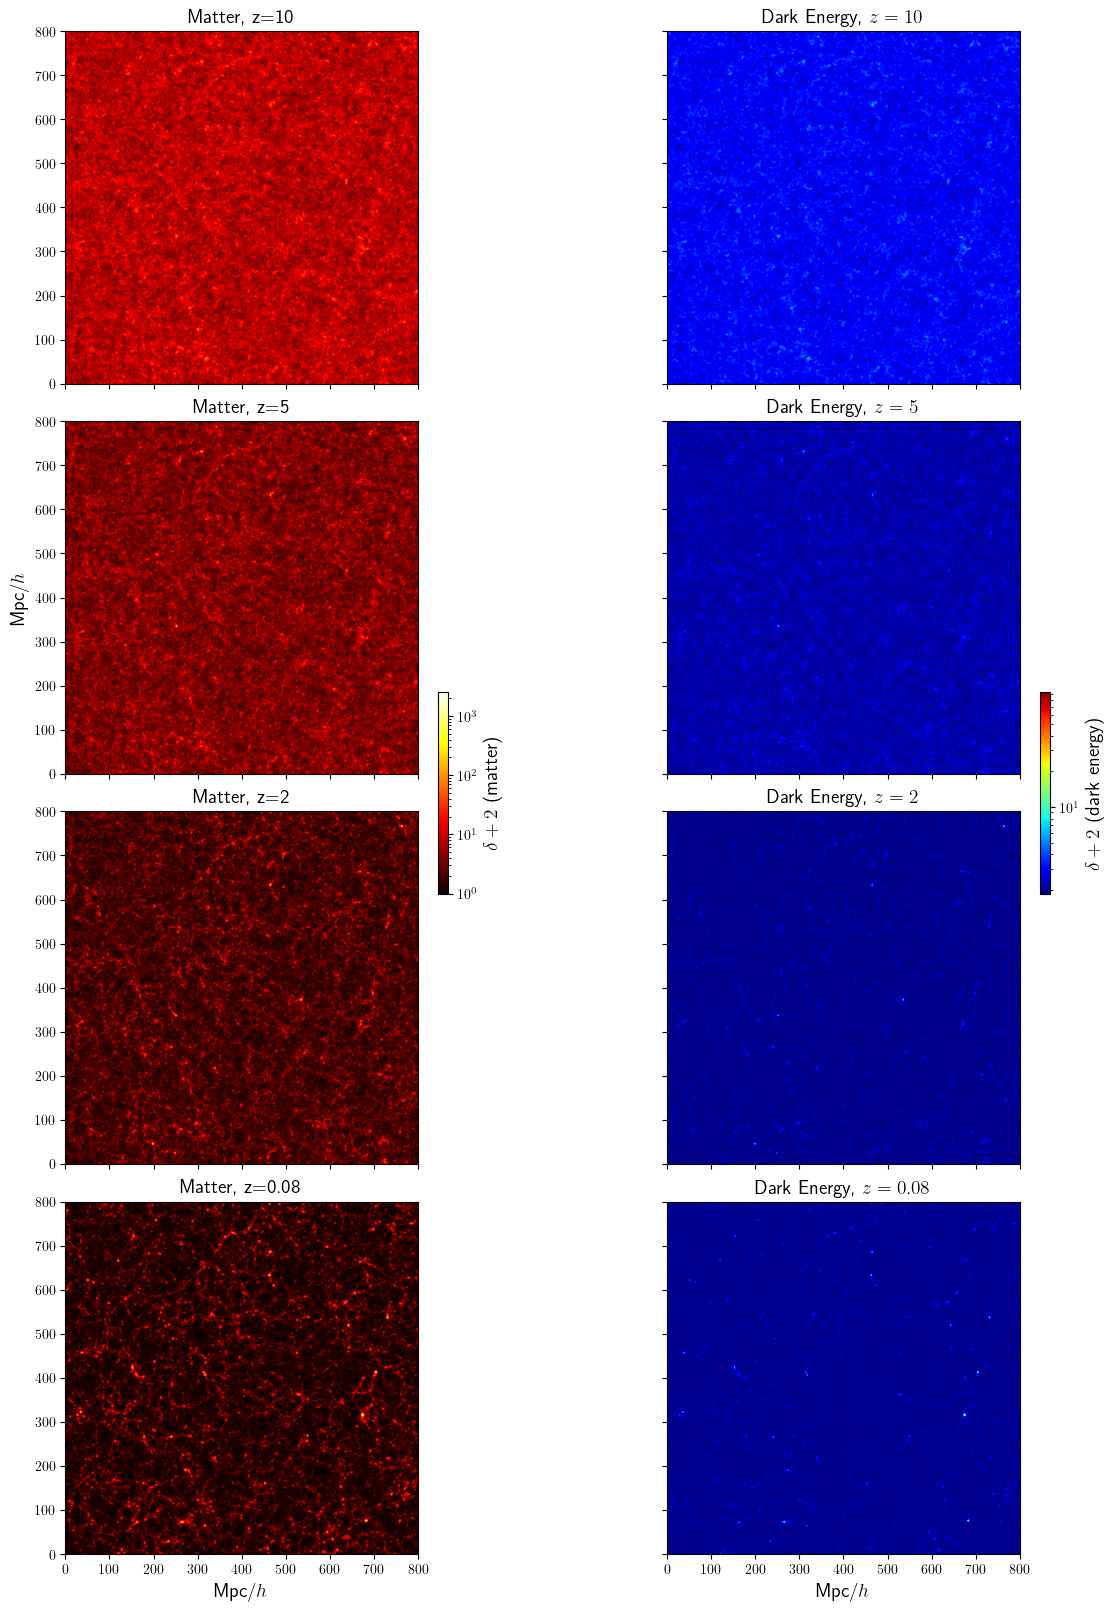

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm     import get_cmap

# --- parameters ---
Ngrid     = 1200
boxsize   = 800
cmap      = "hot"
cmap_de   = "jet"
redshifts = [10, 5, 2, 0.08]   

fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(12, 4*4),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, z in enumerate(redshifts):
    #  Matter 
    mdata   = matter_snapshots[i]['data']
    mean_m  = np.mean(mdata)
    zi_m    = mdata[:Ngrid, :Ngrid, 20] / mean_m + 1
    im_m    = axes[i,0].imshow(
                 zi_m,
                 cmap=get_cmap(cmap),
                 origin='lower',
                 extent=[0,boxsize,0,boxsize],
                 interpolation='bicubic',
                 norm=LogNorm(vmin=zi_m.min(), vmax=zi_m.max())
              )
    axes[i,0].set_title(f"Matter, z={z}", fontsize=14)

    # Dark energy
    ddata    = dark_snapshots[i]['data']
    delta_r  = ddata[:Ngrid, :Ngrid, 20]               
    rho_bg   = (rho_smg_f(z)/rho_crit(0))*((1/(1+z))**3)                           
   
    zi_d     = delta_r / rho_bg + 2             
    im_d     = axes[i,1].imshow(
                  zi_d,
                  cmap=get_cmap(cmap_de),
                  origin='lower',
                  extent=[0,boxsize,0,boxsize],
                  interpolation='bicubic',
                  norm=LogNorm(vmin=zi_d.min(), vmax=zi_d.max())
               )
    axes[i,1].set_title(r"Dark Energy, $z={}$".format(z), fontsize=14)


for col in (0,1):
    axes[-1,col].set_xlabel("Mpc/$h$", fontsize=14)

axes[1,0].set_ylabel("Mpc/$h$", fontsize=14)


cbar_m = fig.colorbar(im_m, ax=axes[:,0], orientation='vertical',
                      fraction=0.02, pad=0.02)
cbar_m.set_label(r"$\delta + 2$ (matter)", fontsize=14)

cbar_d = fig.colorbar(im_d, ax=axes[:,1], orientation='vertical',
                      fraction=0.02, pad=0.02)
cbar_d.set_label(r"$\delta + 2$ (dark energy)", fontsize=14)

plt.show()


In [227]:
for i, z in enumerate(redshifts):
    #  Matter 
    mdata   = matter_snapshots[i]['data']
    mean_m  = np.mean(mdata)
    zi_m    = mdata[:Ngrid, :Ngrid, 20] / mean_m -1
    
    print(np.min(zi_m))

-0.8742926882001708
-1.0
-1.0
-1.0


In [214]:
ddata    = dark_snapshots[3]['data']
delta_r  = ddata[:Ngrid, :Ngrid, 20]   

In [228]:
np.min(delta_r/(rho_smg_f(0.08)/rho_crit(0))*((1/(1+0.08))**3) +2 )

1.9143348753549148

# $w(z)$

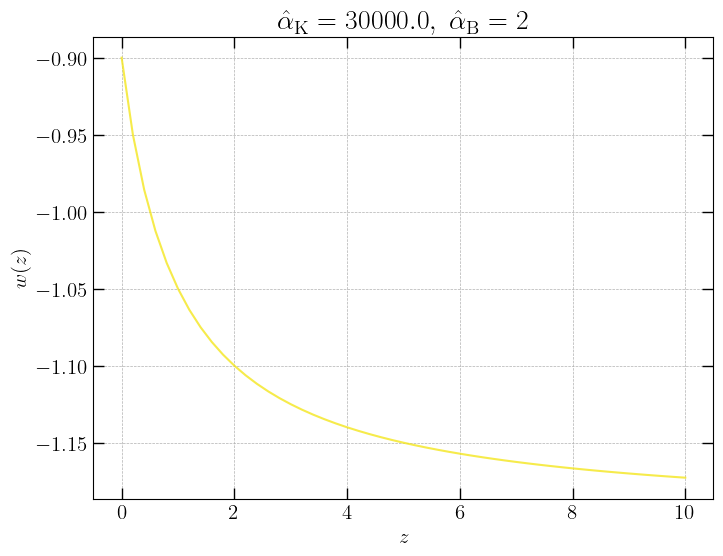

In [13]:
fig, ax = plt.subplots(
    1, 1, figsize=(8, 6), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

#z = list(range(10, -1, -1))
z = list(np.arange(10, -0.001, -0.2))


ax.plot(
    z,
    p_smg(z)/rho_smg(z),"-",
    c = c[zind],
    #label="hiclass_kgb, $z=$" + str(z[zind]),
    alpha = 0.8,
    markersize=6
)


ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)
ax.tick_params("both", length=8, width=1, which="major")
ax.tick_params("both", length=3.5, width=0.8, which="minor")
ax.tick_params(direction="in", which="major", labelsize=15)
ax.tick_params(direction="in", which="minor")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")


#ax[0].set_yscale("log")
ax.set_ylabel(r"$w(z)$", fontsize=15)
#ax[1].set_ylabel(r"$1-P_\mathrm{kess}/P_\mathrm{kgb}~ [\%]$", fontsize=15)
ax.set_xlabel("$z$", fontsize=15)


ax.set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}


In [6]:
import h5py

snap_path_kgb = "/home/ahmad/kgb-master/data/snapshots/"
snap_path_kess = "/home/ahmad/kgb-master/data/snapshots-kess/"

import h5py
import glob

# Define filename patterns for dark energy and matter snapshots
dark_kgb = snap_path_kgb +'/snap_*_T00_kgb.h5'
dark_kess = snap_path_kess+ '/snap_*_T00_kgb.h5'

# Collect and sort matching file paths
dark_files_kgb = sorted(glob.glob(dark_kgb))
dark_files_kess = sorted(glob.glob(dark_kess))


# Open HDF5 files and store file objects in separate lists
dark_snapshots_kgb = [h5py.File(f, 'r') for f in dark_files_kgb]
dark_snapshots_kess = [h5py.File(f, 'r') for f in dark_files_kess]

# Example: Access a dataset from the first dark energy snapshot
# coords_dark = dark_snapshots[0]['PartType1/Coordinates'][:]
# coords_matter = matter_snapshots[0]['PartType1/Coordinates'][:]

# When you're done processing, remember to close all files:
# for f in dark_snapshots + matter_snapshots:
#     f.close()

print("Dark energy kgb files loaded:", dark_files_kgb)
print("Dark energy kess files loaded:", dark_files_kess)

Dark energy kgb files loaded: ['/home/ahmad/kgb-master/data/snapshots/snap_000_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_001_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_002_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots/snap_003_T00_kgb.h5']
Dark energy kess files loaded: ['/home/ahmad/kgb-master/data/snapshots-kess/snap_000_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots-kess/snap_001_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots-kess/snap_002_T00_kgb.h5', '/home/ahmad/kgb-master/data/snapshots-kess/snap_003_T00_kgb.h5']


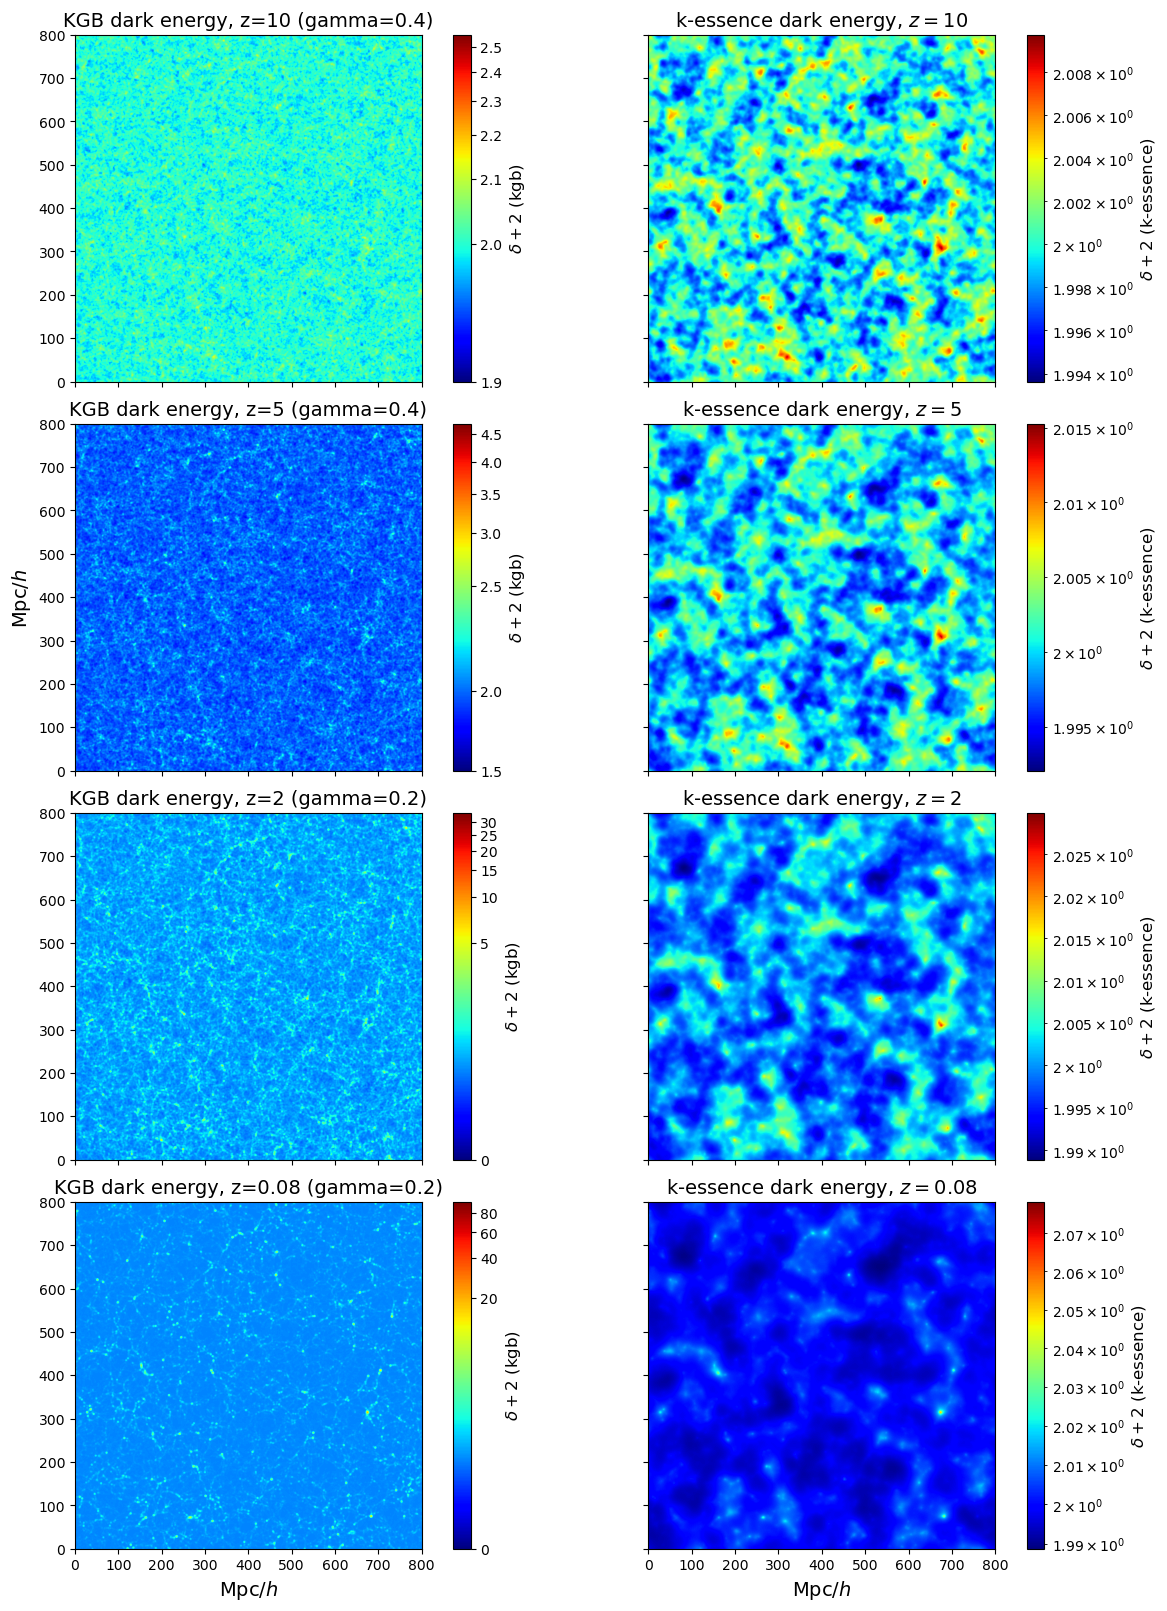

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from matplotlib.cm import get_cmap

# --- parameters ---
Ngrid     = 1200
boxsize   = 800
cmap_de   = "jet"
redshifts = [10, 5, 2, 0.08]

# (Assumes `rho_smg_f(z)` and `rho_crit_f(z)` are defined elsewhere in your environment)
# and that `dark_snapshots_kgb`/`dark_snapshots_kess` are loaded lists of snapshots


fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(12, 4*4),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, z in enumerate(redshifts):
    # --- Determine gamma based on redshift ---
    if z in (10, 5):
        gamma_val = 0.4    # boost filaments moderately
    else:
        gamma_val = 0.2   # invert contrast for low-z snapshots

    # --- KGB panel with conditional PowerNorm ---
    mdata       = dark_snapshots_kgb[i]['data']
    delta_r_kgb = mdata[:Ngrid, :Ngrid, 20]
    rho_bg_kgb  = (rho_smg_f(z) / rho_crit_f(0)) * ((1/(1+z))**3)
    zi_d_kgb    = delta_r_kgb / rho_bg_kgb + 2

    norm_kgb = PowerNorm(
        gamma=gamma_val,
        vmin=zi_d_kgb.min(),
        vmax=zi_d_kgb.max()
    )

    im_kgb = axes[i, 0].imshow(
        zi_d_kgb,
        cmap=get_cmap(cmap_de),
        norm=norm_kgb,
        origin='lower',
        extent=[0, boxsize, 0, boxsize],
        interpolation='bicubic'
    )
    axes[i, 0].set_title(f"KGB dark energy, z={z} (gamma={gamma_val})", fontsize=14)
    cbar_kgb = fig.colorbar(im_kgb, ax=axes[i, 0],
                             orientation='vertical', fraction=0.046, pad=0.04)
    cbar_kgb.set_label(r"$\delta + 2$ (kgb)", fontsize=12)

    # --- k-essence panel ---
    ddata    = dark_snapshots_kess[i]['data']
    delta_r  = ddata[:Ngrid, :Ngrid, 20]
    rho_bg   = (rho_smg_f(z) / rho_crit_f(0)) * ((1/(1+z))**3)
    zi_d     = delta_r / rho_bg + 2

    im_kess = axes[i, 1].imshow(
        zi_d,
        cmap=get_cmap(cmap_de),
        norm=LogNorm(vmin=zi_d.min(), vmax=zi_d.max()),
        origin='lower',
        extent=[0, boxsize, 0, boxsize],
        interpolation='bicubic'
    )
    axes[i, 1].set_title(r"k-essence dark energy, $z={}$".format(z), fontsize=14)
    cbar_kess = fig.colorbar(im_kess, ax=axes[i, 1],
                              orientation='vertical', fraction=0.046, pad=0.04)
    cbar_kess.set_label(r"$\delta + 2$ (k-essence)", fontsize=12)

# set axis labels
for col in (0, 1):
    axes[-1, col].set_xlabel("Mpc/$h$", fontsize=14)
axes[1, 0].set_ylabel("Mpc/$h$", fontsize=14)

plt.show()



In [ ]:
# from configparser import ConfigParser
# from itertools import chain

# ############################################################################################################ 
# #                                               data path

# #folder_name_kgb = '/home/ahmad/kgb-master/output'
# folder_name_kgb = '/home/ahmad/kgb-master/data/3072-90000/'
# #folder_name_kgb = '/home/ahmad/kgb-master/data/2048-800/'


# ############################################################################################################ 
# #                                              background file


# with open(f"{folder_name_kgb}/file_background.dat") as f:
#     lines = f.readlines()

# fourpiG_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")))
# H0_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# H0[1/Mpc]")))

# norm_kgb = np.sqrt(2*fourpiG_val/3)/H0_val

# bg_kgb = np.loadtxt(f"{folder_name_kgb}/file_background.dat")

# # scale factor and redshift
# a_kgb = bg_kgb[:,2]
# z_kgb = bg_kgb[:,3]

# # z_kgb = [0 if x < 0 else x for x in z_kgb]
# # z_kgb[-2], z_kgb[-1] = 0.01, 0


# # Conformal Hubble parameter and its derivative 
# Hconf_kgb = bg_kgb[:,5]
# Hconf_prime_kgb = bg_kgb[:,6]
# Hconf_prime_prime_kgb = bg_kgb[:,7]


# # alpha parameters and their derivatives
# alpha_K_kgb = bg_kgb[:,17]
# alpha_B_kgb = bg_kgb[:,18]
# alpha_K_prime_kgb = bg_kgb[:,19]
# alpha_B_prime_kgb = bg_kgb[:,20]

# # dark energy density and pressure and their derivatives
# rho_smg_kgb = bg_kgb[:,13]
# p_smg_kgb = bg_kgb[:,14]
# rho_smg_prime_kgb = bg_kgb[:,15]
# p_smg_prime_kgb = bg_kgb[:,16]
# cs2_kgb = bg_kgb[:,21]

# H_hiclass =  bg_kgb[:,4]

# # other background values
# rho_cdm_kgb = bg_kgb[:,8]
# rho_b_kgb = bg_kgb[:,9]

# ############################################################################################################ 
# #                                         hiclass ini parameters

# parser = ConfigParser()
# with open(f"{folder_name_kgb}/file_classparameters.ini") as lines:
#     lines = chain(("[top]",), lines) # This line produce a fake section header called top
#     parser.read_file(lines)

# Omega_fld = float(parser.get("top", "Omega_fld"))
# Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
# Omega_smg= float(parser.get("top", "Omega_smg"))

# Omega_b = float(parser.get("top", "Omega_b"))
# Omega_cdm = float(parser.get("top", "Omega_cdm"))
# Omega_g = float(parser.get("top", "Omega_g"))
# Omega_ur = float(parser.get("top", "Omega_ur"))

# # Extract and parse the 'parameters_smg' string
# expansion_smg_str = parser.get("top", "expansion_smg")
# expansion_smg_list = expansion_smg_str.split(',')
# Omega_kgb = float(expansion_smg_list[0].strip())

# expansion_model_str = parser.get("top", "expansion_model")

# ############################################################################################################ 
# #                                   KGB-evolution used.ini parameters

# with open(f"{folder_name_kgb}/file_settings_used.ini") as lines:
#     lines = chain(("[top]",), lines) # This line produce a fake section header called top
#     parser.read_file(lines)

# k_pivot = float(parser.get("top", "k_pivot"))     
# A_s = float(parser.get("top", "A_s"))   
# n_s = float(parser.get("top", "n_s"))
# h = float(parser.get("top", "h"))

# omega_b = float(parser.get("top", "omega_b"))
# omega_cdm = float(parser.get("top", "omega_cdm"))


# gravity_model = (parser.get("top", "gravity_model"))
    
# # Extract and parse the 'parameters_smg' string
# parameters_smg_str = parser.get("top", "parameters_smg")
# parameters_smg_list = parameters_smg_str.split(',')
    
# # Convert the first two parameters to floats
# alpha_K_hat = float(parameters_smg_list[0].strip())
# alpha_B_hat = float(parameters_smg_list[1].strip())    



# # Function to format numbers for LaTeX (reusing the previous function)
# def format_scientific_latex(number):
#     mantissa, exponent = f"{number:.1e}".split('e')
#     exponent = exponent.lstrip('+').lstrip('0') or '0'
#     return f"{mantissa} \\times 10^{{{exponent}}}"

# # Format the alpha values
# alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# # Extract and parse the 'parameters_smg' string
# expansion_smg_str = parser.get("top", "expansion_smg")
# expansion_smg_list = expansion_smg_str.split(',')

# w_kgb = float(expansion_smg_list[0].strip())
# w_a_kgb = float(expansion_smg_list[1].strip())

# boxsize = float(parser.get("top", "boxsize"))
# Ngrid = float(parser.get("top", "Ngrid"))

# boxsize = int(boxsize)
# Ngrid = int(Ngrid)

# # z_snap = float(parser.get("top", "snapshot redshifts"))
# # a_snap = 1/(1+z_snap)

# k_nyq = np.pi*Ngrid/boxsize
# dx = boxsize/Ngrid

# n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
# Courant_factor = float(parser.get("top", "Courant factor"))


# Omega_Lambda = float(parser.get("top", "Omega_Lambda"))

# # reading Pk the redshifts
# z = []

# with open(f'{folder_name_kgb}/file_settings_used.ini', 'r') as f:
#     for line in f:
#         if line.startswith('Pk redshifts'):
#             # Extract the part after '=' and split by commas
#             redshifts_string = line.split('=')[1].split('#')[0].strip()  # Remove comments after #
#             z = [float(x.strip()) for x in redshifts_string.split(',')]  # Parse as floats

# redshifts = z

# colors_plot = sns.color_palette("inferno", len(z)).as_hex()


# delta_rho_kgb = [None] * len(z)
# mu = [None] * len(z)
# mu_corr =[None] * len(z)

# pk_phi_kgb = [None] * len(z)
# pk_phi_prime_kgb = [None] * len(z)

# pk_matter_kgb = [None] * len(z)
# pk_pi_kgb = [None] * len(z)
# pk_zeta_kgb = [None] * len(z)

# f_rho_fld = interp1d(z_kgb, rho_smg_kgb, kind='linear')
# f_rho_cdm = interp1d(z_kgb, rho_cdm_kgb, kind='linear')
# f_rho_b = interp1d(z_kgb, rho_b_kgb, kind='linear')


# def rho_m_kgb_f(val):
#     return f_rho_cdm(val) + f_rho_b(val)

# def rho_smg_kgb_f(val):
#     return f_rho_fld(val)

# for zind, zval in list(enumerate(z)):
    
#     file_index = str(zind).zfill(2)
    
#     data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_delta_kgb.dat"
#     )
#     data_kgb["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_delta.dat"
#     )
    
#     data_kgb["kgb"]["phi"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_phi.dat"
#     )
    
#     data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_phi_prime.dat"
#     )
    
#     data_kgb["kgb"]["pi"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
#     )
    
#     data_kgb["kgb"]["zeta"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_zeta.dat"
#     )
#     data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])] = np.loadtxt(
#         f"{folder_name_kgb}/pk_0{file_index}_deltakgb_deltam.dat"
#     )
    
#     k = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 0]
    
#     pk_kgb_delta_kgb = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 1]

#     pk_kgb_delta = data_kgb["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_phi = data_kgb["kgb"]["phi"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_phi_prime = data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_pi = data_kgb["kgb"]["pi"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_zeta = data_kgb["kgb"]["zeta"]["z=" + str(z[zind])][:, 1]
    
#     pk_kgb_deltakgb_deltam = data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])][:, 1]
    
#     norm = (2*(np.pi)**2)/((k)**3)
    
#     delta_rho_kgb[zind] = pk_kgb_delta_kgb 
#     pk_phi_kgb[zind] = pk_kgb_phi
#     pk_phi_prime_kgb[zind] = pk_kgb_phi_prime
#     pk_matter_kgb[zind] = pk_kgb_delta * norm
    
#     pk_pi_kgb[zind] = pk_kgb_pi
#     pk_zeta_kgb[zind] = pk_kgb_zeta
    
    
    
    
#     mu[zind] = 1 + (rho_smg_kgb_f(zval)*np.sqrt(pk_kgb_delta_kgb))/(rho_m_kgb_f(zval)*np.sqrt(pk_kgb_delta))
#     mu_corr[zind] = np.sqrt(
#     ((rho_smg_kgb_f(zval) ** 2) * pk_kgb_delta_kgb + (rho_m_kgb_f(zval) ** 2) * pk_kgb_delta
#         + 2 * (rho_m_kgb_f(zval) * rho_smg_kgb_f(zval)) * pk_kgb_deltakgb_deltam)
#     / ((rho_m_kgb_f(zval) ** 2) * pk_kgb_delta)
#     )
#     #kk_kgb = k
    
#     ind_nyq       = [i for i, v in enumerate(k) if k_nyq*0.75 < v ][0]
#     #ind_nyq =-1
#     kk_kgb        = k[:ind_nyq]
    
#     mu[zind]      = mu[zind][:ind_nyq]
#     delta_rho_kgb[zind]  =  delta_rho_kgb[zind][:ind_nyq]
    
#     pk_phi_kgb[zind] = pk_phi_kgb[zind][:ind_nyq]
#     pk_phi_prime_kgb[zind] = pk_phi_prime_kgb[zind][:ind_nyq]
#     pk_matter_kgb[zind] =pk_matter_kgb[zind][:ind_nyq]
#     pk_pi_kgb[zind] =  pk_pi_kgb[zind][:ind_nyq]
#     pk_zeta_kgb[zind] = pk_zeta_kgb[zind][:ind_nyq]
    
#     mu_corr[zind] = mu_corr[zind][:ind_nyq]

# $\Lambda$CDM

In [ ]:
# delta_smg_CLASS = [None] * len(z)

# LCDM_settings ={
#         "Omega_scf": 0,
#         "Omega_Lambda": 0,
#         "cs2_fld": 1e-7,
#         "w0_fld": -1,
#         "wa_fld":0,
#         "h": 0.67556,
#         "omega_b": 0.022032,
#         "omega_cdm": 0.12038,
#         "A_s": 2.215e-9,
#         "n_s": 0.9619,
#         "z_max_pk": 100,
#         "tau_reio": 0.05430842,
#         "N_ur":3.046,
#         "gauge":"Newtonian",
#         "output": "vTk,mTk,mPk",
#         "use_ppf":"yes",
#         "P_k_max_1/Mpc": 192,
#     }

# M_LCDM = Class()
# M_LCDM.set(LCDM_settings)
# M_LCDM.compute()


# backgrounds = M_LCDM.get_background()

# rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
# rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
# rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
# rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
# rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
# rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

# H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
# H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


# rho_fld = interp1d(backgrounds["z"], backgrounds["(.)rho_fld"], kind="cubic")
# w_fld = interp1d(backgrounds["z"], backgrounds["(.)w_fld"], kind="cubic")

# for zind, z_val in enumerate(z):

#     Transfers_CLASS = M_LCDM.get_transfer(z_val)

#     #############
#     delta_b_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_b"], kind="cubic"
#     )
#     theta_b_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_b"], kind="cubic"
#     )
#     #############
#     #                         theta_cdm is zero in synchronous gauge
#     delta_cdm_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_cdm"], kind="cubic"
#     )
#     #############
#     delta_fld_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_fld"], kind="cubic"
#     )
#     theta_fld_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_fld"], kind="cubic"
#     )
#     #############
#     delta_g_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_g"], kind="cubic"
#     )
#     theta_g_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_g"], kind="cubic"
#     )
#     #############
#     delta_ur_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_ur"], kind="cubic"
#     )
#     theta_ur_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_ur"], kind="cubic"
#     )
#     #############

#     delta_tot_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["d_tot"], kind="cubic"
#     )

#     theta_tot_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["t_tot"], kind="cubic"
#     )

#     phi_CLASS = interp1d(Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["phi"], kind="cubic")

#     phi_prime_CLASS = interp1d(
#         Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["phi_prime"], kind="cubic"
#     )
#     psi_CLASS = interp1d(Transfers_CLASS["k (h/Mpc)"], Transfers_CLASS["psi"], kind="cubic")
    
#     delta_smg_CLASS[zind] = delta_fld_CLASS(kk)
    